In [2]:
from datetime import datetime
from datetime import timedelta

import pandas
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set_style("ticks")

## Load and Prepare Data

In [3]:
df = pandas.read_csv("troon_instagram_clean_post_data.csv")
df = df.set_index("id")
df = df[["post_month", "post_day", "post_year", "days_since_previous_release", "release_post"]].copy()
df["month"] = df["post_month"].apply(lambda x : datetime.strptime(x, '%B').month)
df = df.rename(columns={"post_year" : "year", "post_day" : "day"})
df["date"] = pandas.to_datetime(df[["year", "month", "day"]])
del df["month"]
del df["day"]
del df["year"]
del df["post_month"]

In [4]:
df.query("release_post == True & days_since_previous_release.isnull()")

,days_since_previous_release,release_post,date
id,,,


In [5]:
df = df[df["days_since_previous_release"].notnull()].copy()

In [6]:
filled_in = [dict(df.iloc[0])]
# df should already be sorted by date
current_date = filled_in[0]["date"]
days_since_release = filled_in[0]["days_since_previous_release"] # should be 0
while current_date < df.iloc[-1]["date"]:
    days_since_release += 1
    current_date = current_date + timedelta(days=1)
    in_df = df[df["date"] == current_date]
    if len(in_df) == 1:
        filled_in.append({"date" : current_date, "release_post" : in_df.iloc[0]["release_post"],
                          "days_since_previous_release" : days_since_release})
        days_since_release = 0
    else:
        filled_in.append({"date" : current_date, "release_post" : False,
                          "days_since_previous_release" : days_since_release})
        
features_df = pandas.DataFrame(filled_in)
features_df.tail()

,days_since_previous_release,release_post,date
1559,6.0,False,2021-05-26
1560,7.0,False,2021-05-27
1561,8.0,False,2021-05-28
1562,9.0,False,2021-05-29
1563,10.0,True,2021-05-30


In [7]:
features_df["release_post"].value_counts()

False    1363
True      201
Name: release_post, dtype: int64

In [8]:
features_df["weekday"] = features_df["date"].apply(lambda x : x.weekday())
features_df["month"] = features_df["date"].apply(lambda x : x.month)
features_df.tail()

,days_since_previous_release,release_post,date,weekday,month
1559,6.0,False,2021-05-26,2,5
1560,7.0,False,2021-05-27,3,5
1561,8.0,False,2021-05-28,4,5
1562,9.0,False,2021-05-29,5,5
1563,10.0,True,2021-05-30,6,5


In [89]:
train_df = features_df[0:int(len(features_df) * 0.9)].copy()
test_df = features_df[~features_df.index.isin(train_df.index)].copy()
print(len(train_df), len(test_df))

1407 157


In [90]:
train_df = train_df.rename(columns={"date" : "ds", "release_post" : "y"})
test_df = test_df.rename(columns={"date" : "ds", "release_post" : "y"})

---

In [114]:
def evaluate(df):
    print("Pearson =", df[["y", "yhat"]].corr().iloc[0][1])
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    precisions = []
    recalls = []
    for threshold in thresholds:
        tp = len(df.query('y == 1 & yhat >= {}'.format(threshold)))
        fp = len(df.query('y != 1 & yhat >= {}'.format(threshold)))
        fn = len(df.query('y == 1 & yhat < {}'.format(threshold)))
        precisions.append(tp / (tp + fp))
        recalls.append(tp / (tp + fn))
        
    f1s = [(2 * ((p * r) / (p + r)) if p > 0 and r > 0 else 0)
           for (p, r) in zip(precisions, recalls)]
        
    best_index = f1s.index(max(f1s))
    print("Best F1 =", f1s[best_index])
    print("Precision =", precisions[best_index])
    print("Recall =", recalls[best_index])
    print("Threshold =", thresholds[best_index])
        
    sns.lineplot(x=thresholds, y=f1s).set(xlabel="Threshold", ylabel="F1")

---

## No Additional Features or Information

In [92]:
m1 = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)

In [93]:
m1.fit(train_df[["ds", "y"]])

In [94]:
predictions1 = m1.predict(test_df[["ds", "y"]])
scaler = MinMaxScaler()
predictions1["yhat"] = scaler.fit_transform(predictions1[["yhat"]])
# predictions1["yhat"].describe()

In [95]:
predictions1 = predictions1.merge(test_df, on=["ds"])

Pearson = 0.02106489665366845
Best F1 = 0.25609756097560976
Precision = 0.14893617021276595
Recall = 0.9130434782608695
Threshold = 0.1


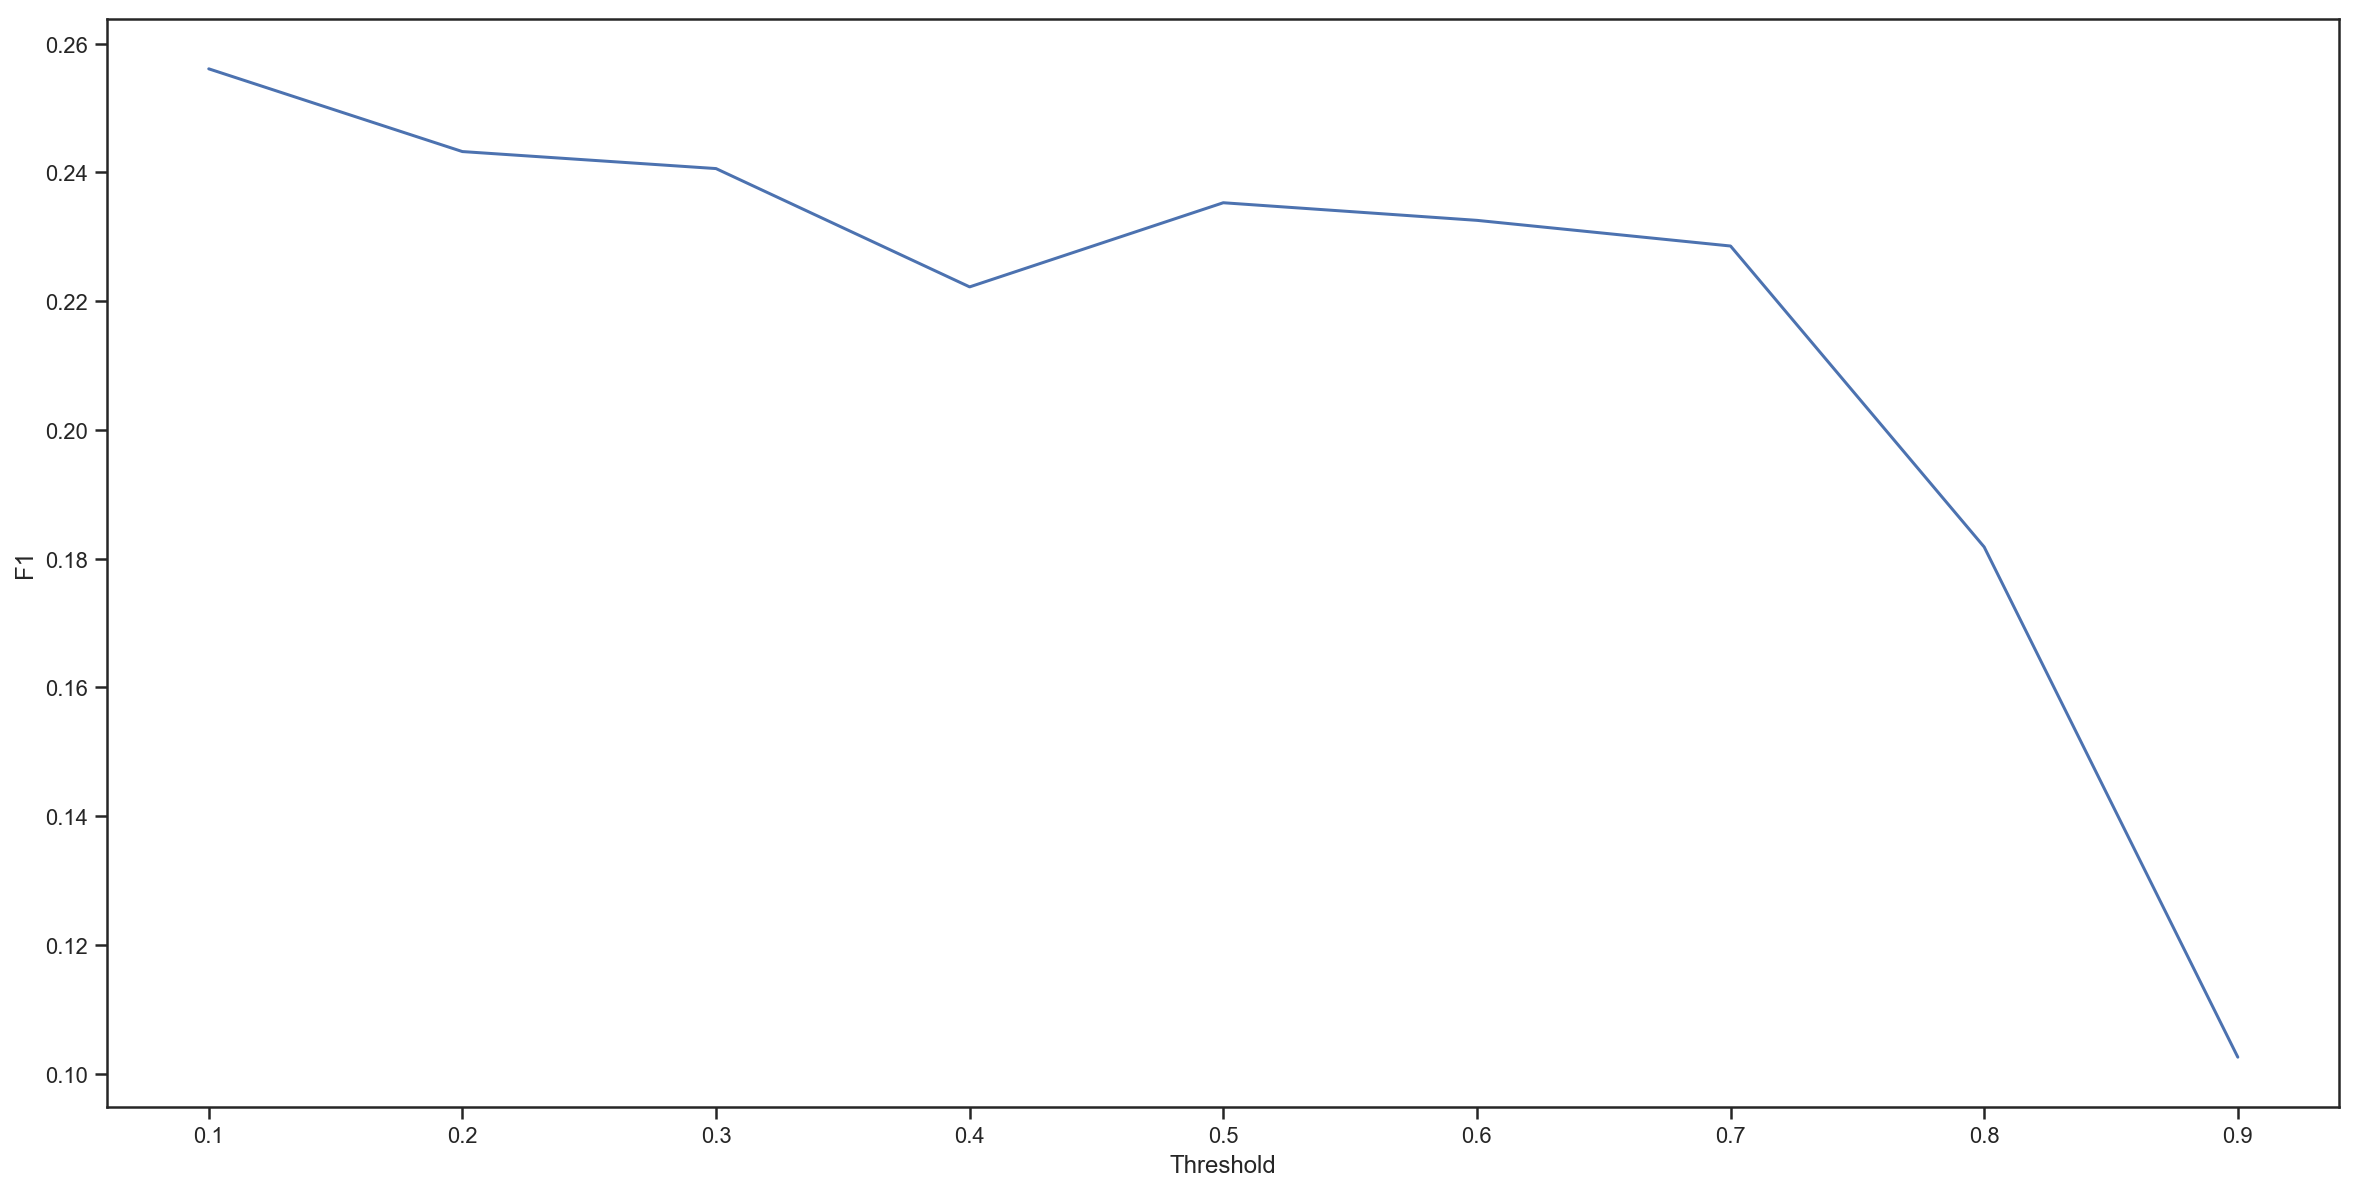

In [96]:
evaluate(predictions1)

In [97]:
# sns.scatterplot(data=predictions1, x="y", y="yhat", hue="y")

In [98]:
# temp = predictions1.copy()
# temp["yhat"] = temp["yhat"].round(2)
# temp = temp.groupby(["y", "yhat"]).size().reset_index()
# sns.scatterplot(data=temp, x="yhat", y=0, hue="y")

---

## Adding Weekly Seasonality

In [99]:
m2 = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)

In [100]:
m2.fit(train_df[["ds", "y"]])

In [101]:
predictions2 = m2.predict(test_df[["ds", "y"]])
scaler = MinMaxScaler()
predictions2["yhat"] = scaler.fit_transform(predictions2[["yhat"]])
# predictions2["yhat"].describe()

In [102]:
predictions2 = predictions2.merge(test_df, on=["ds"])

Pearson = 0.06740753780405294
Best F1 = 0.29411764705882354
Precision = 0.2222222222222222
Recall = 0.43478260869565216
Threshold = 0.7


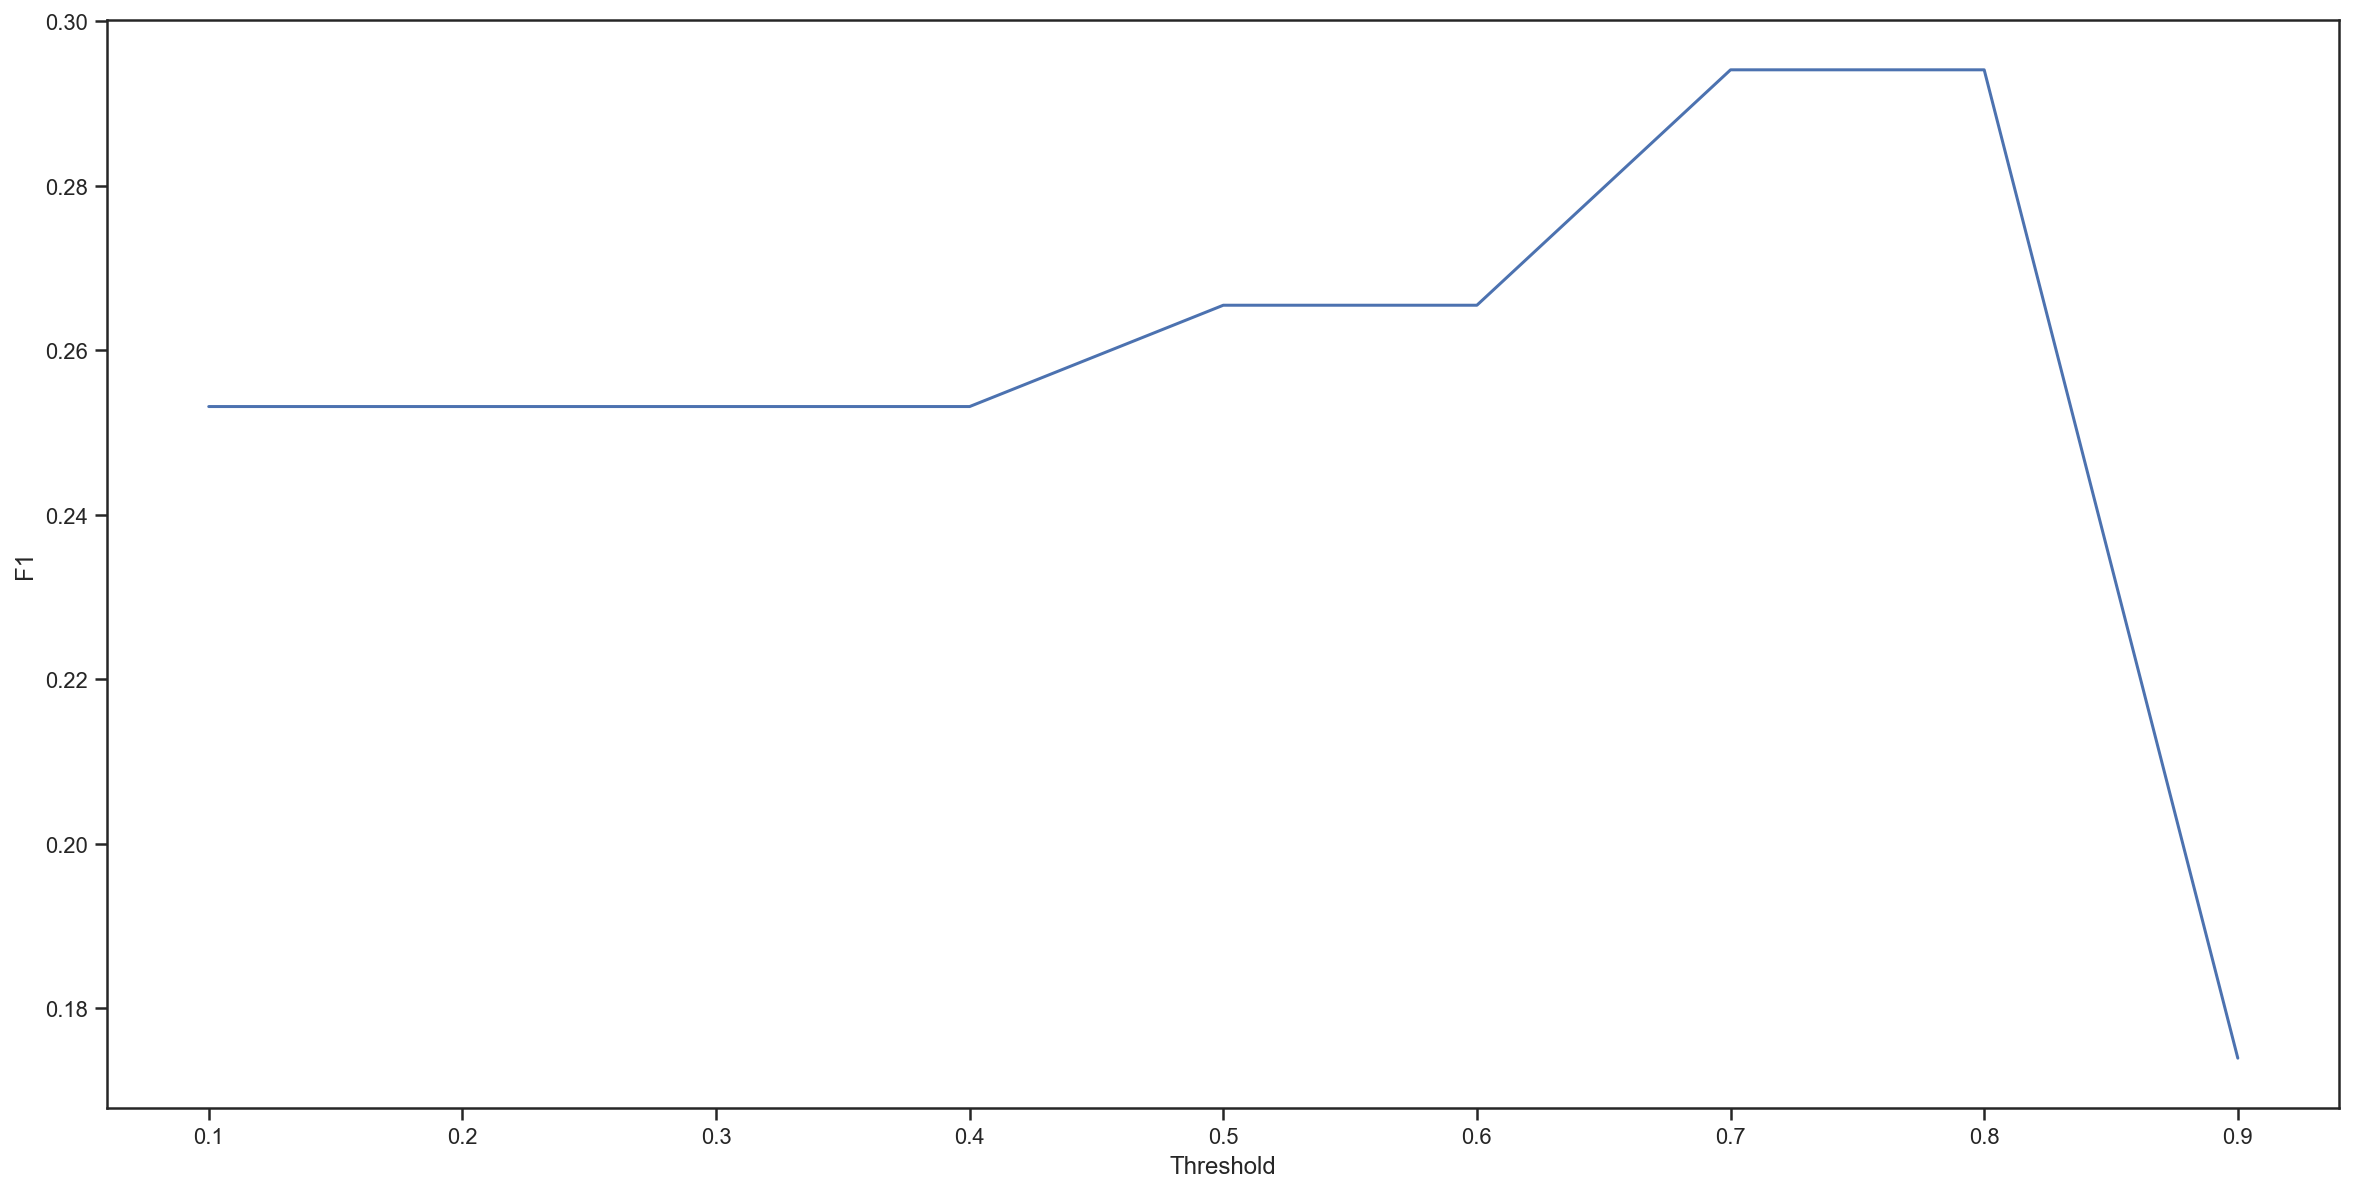

In [103]:
evaluate(predictions2)

---

## Weekly + Daily Seasonality

In [104]:
m3 = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True)

In [105]:
m3.fit(train_df[["ds", "y"]])

In [106]:
predictions3 = m3.predict(test_df[["ds", "y"]])
scaler = MinMaxScaler()
predictions3["yhat"] = scaler.fit_transform(predictions3[["yhat"]])
# predictions3["yhat"].describe()

In [107]:
predictions3 = predictions3.merge(test_df, on=["ds"])

Pearson = 0.06745770888773094
Best F1 = 0.29411764705882354
Precision = 0.2222222222222222
Recall = 0.43478260869565216
Threshold = 0.7


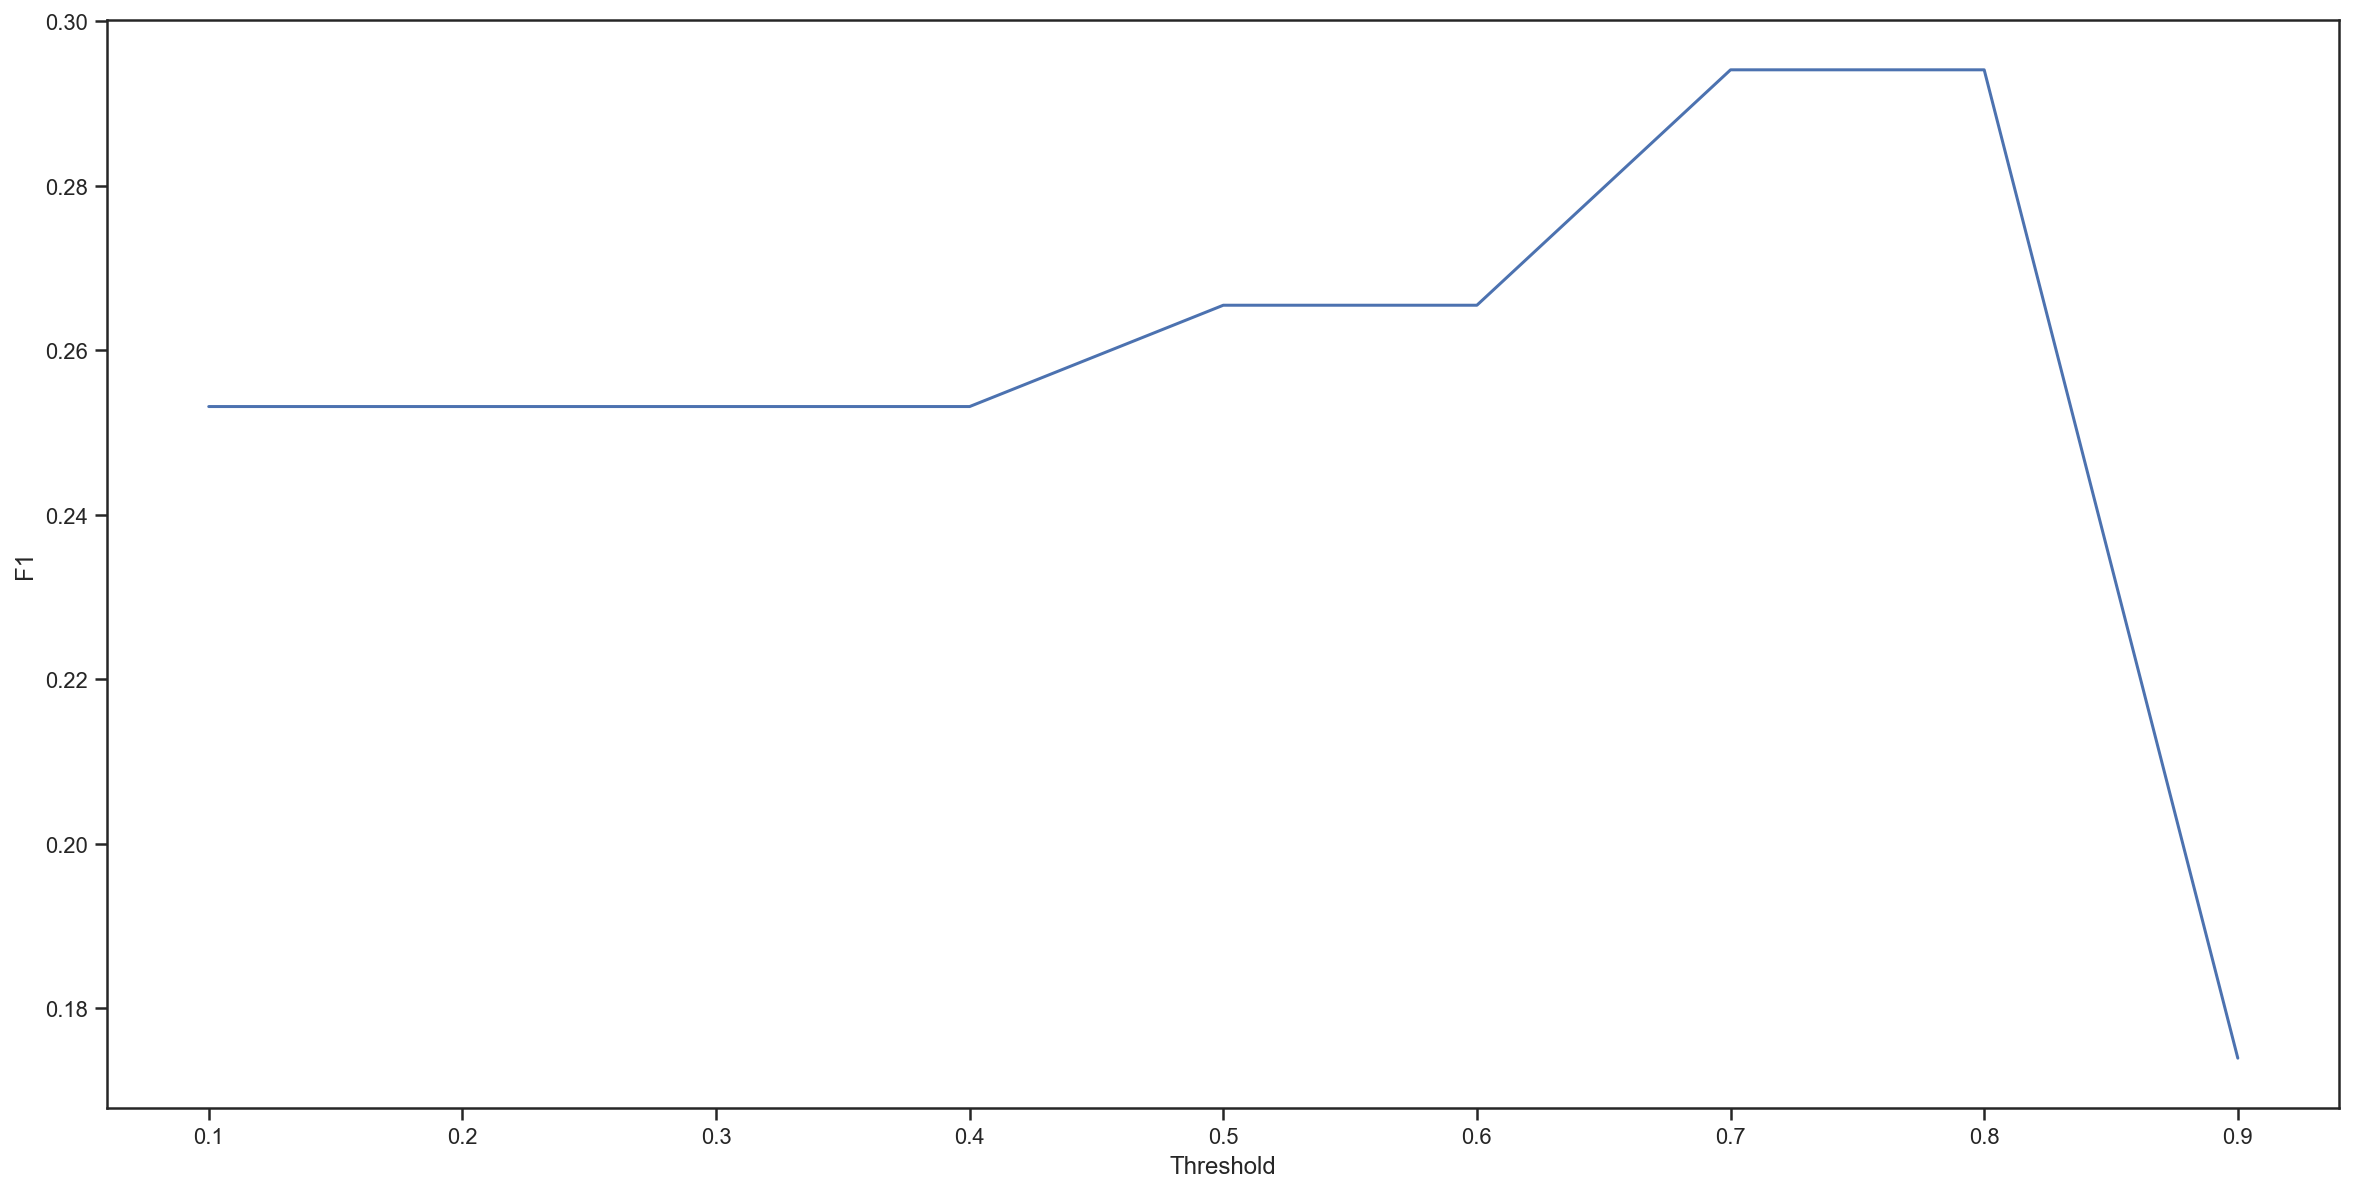

In [108]:
evaluate(predictions3)

---

## Weekly + Yearly Seasonality

In [109]:
m4 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

In [110]:
m4.fit(train_df[["ds", "y"]])

In [111]:
predictions4 = m4.predict(test_df[["ds", "y"]])
scaler = MinMaxScaler()
predictions4["yhat"] = scaler.fit_transform(predictions4[["yhat"]])
# predictions4["yhat"].describe()

In [112]:
predictions4 = predictions4.merge(test_df, on=["ds"])

Pearson = 0.07639486493513781
Best F1 = 0.2782608695652174
Precision = 0.17391304347826086
Recall = 0.6956521739130435
Threshold = 0.5


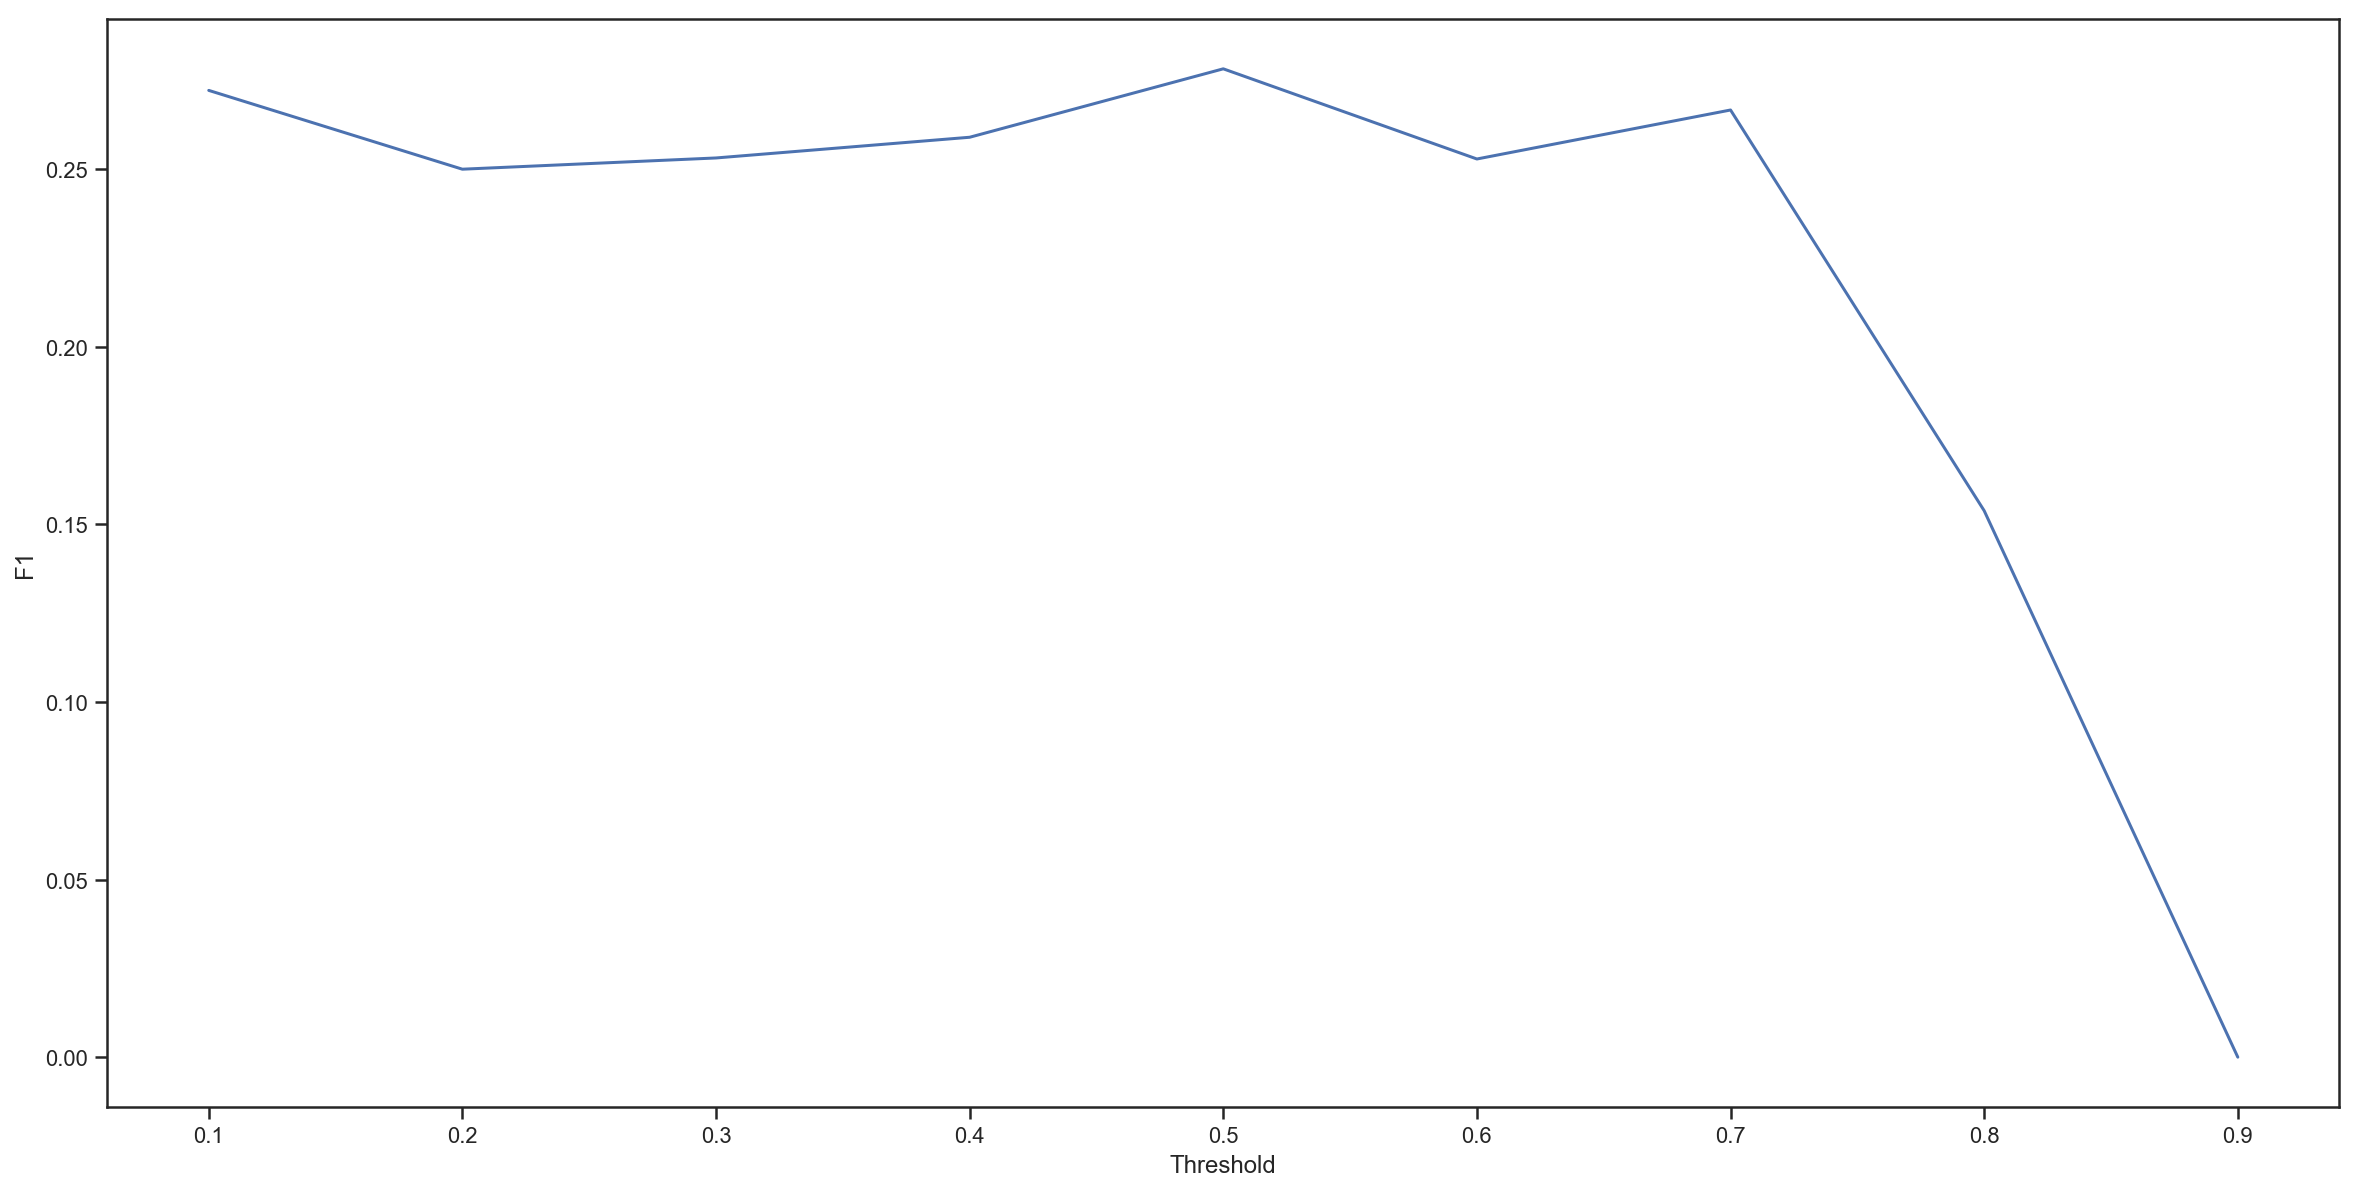

In [115]:
evaluate(predictions4)

---

## Weekly Seasonality + Yearly Seasonality + US Holidays

In [116]:
m5 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m5.add_country_holidays(country_name="US")

In [117]:
m5.fit(train_df[["ds", "y"]])

In [118]:
predictions5 = m5.predict(test_df[["ds", "y"]])
scaler = MinMaxScaler()
predictions5["yhat"] = scaler.fit_transform(predictions5[["yhat"]])
# predictions5["yhat"].describe()

In [119]:
predictions5 = predictions5.merge(test_df, on=["ds"])

Pearson = 0.054224041049431154
Best F1 = 0.27906976744186046
Precision = 0.16981132075471697
Recall = 0.782608695652174
Threshold = 0.5


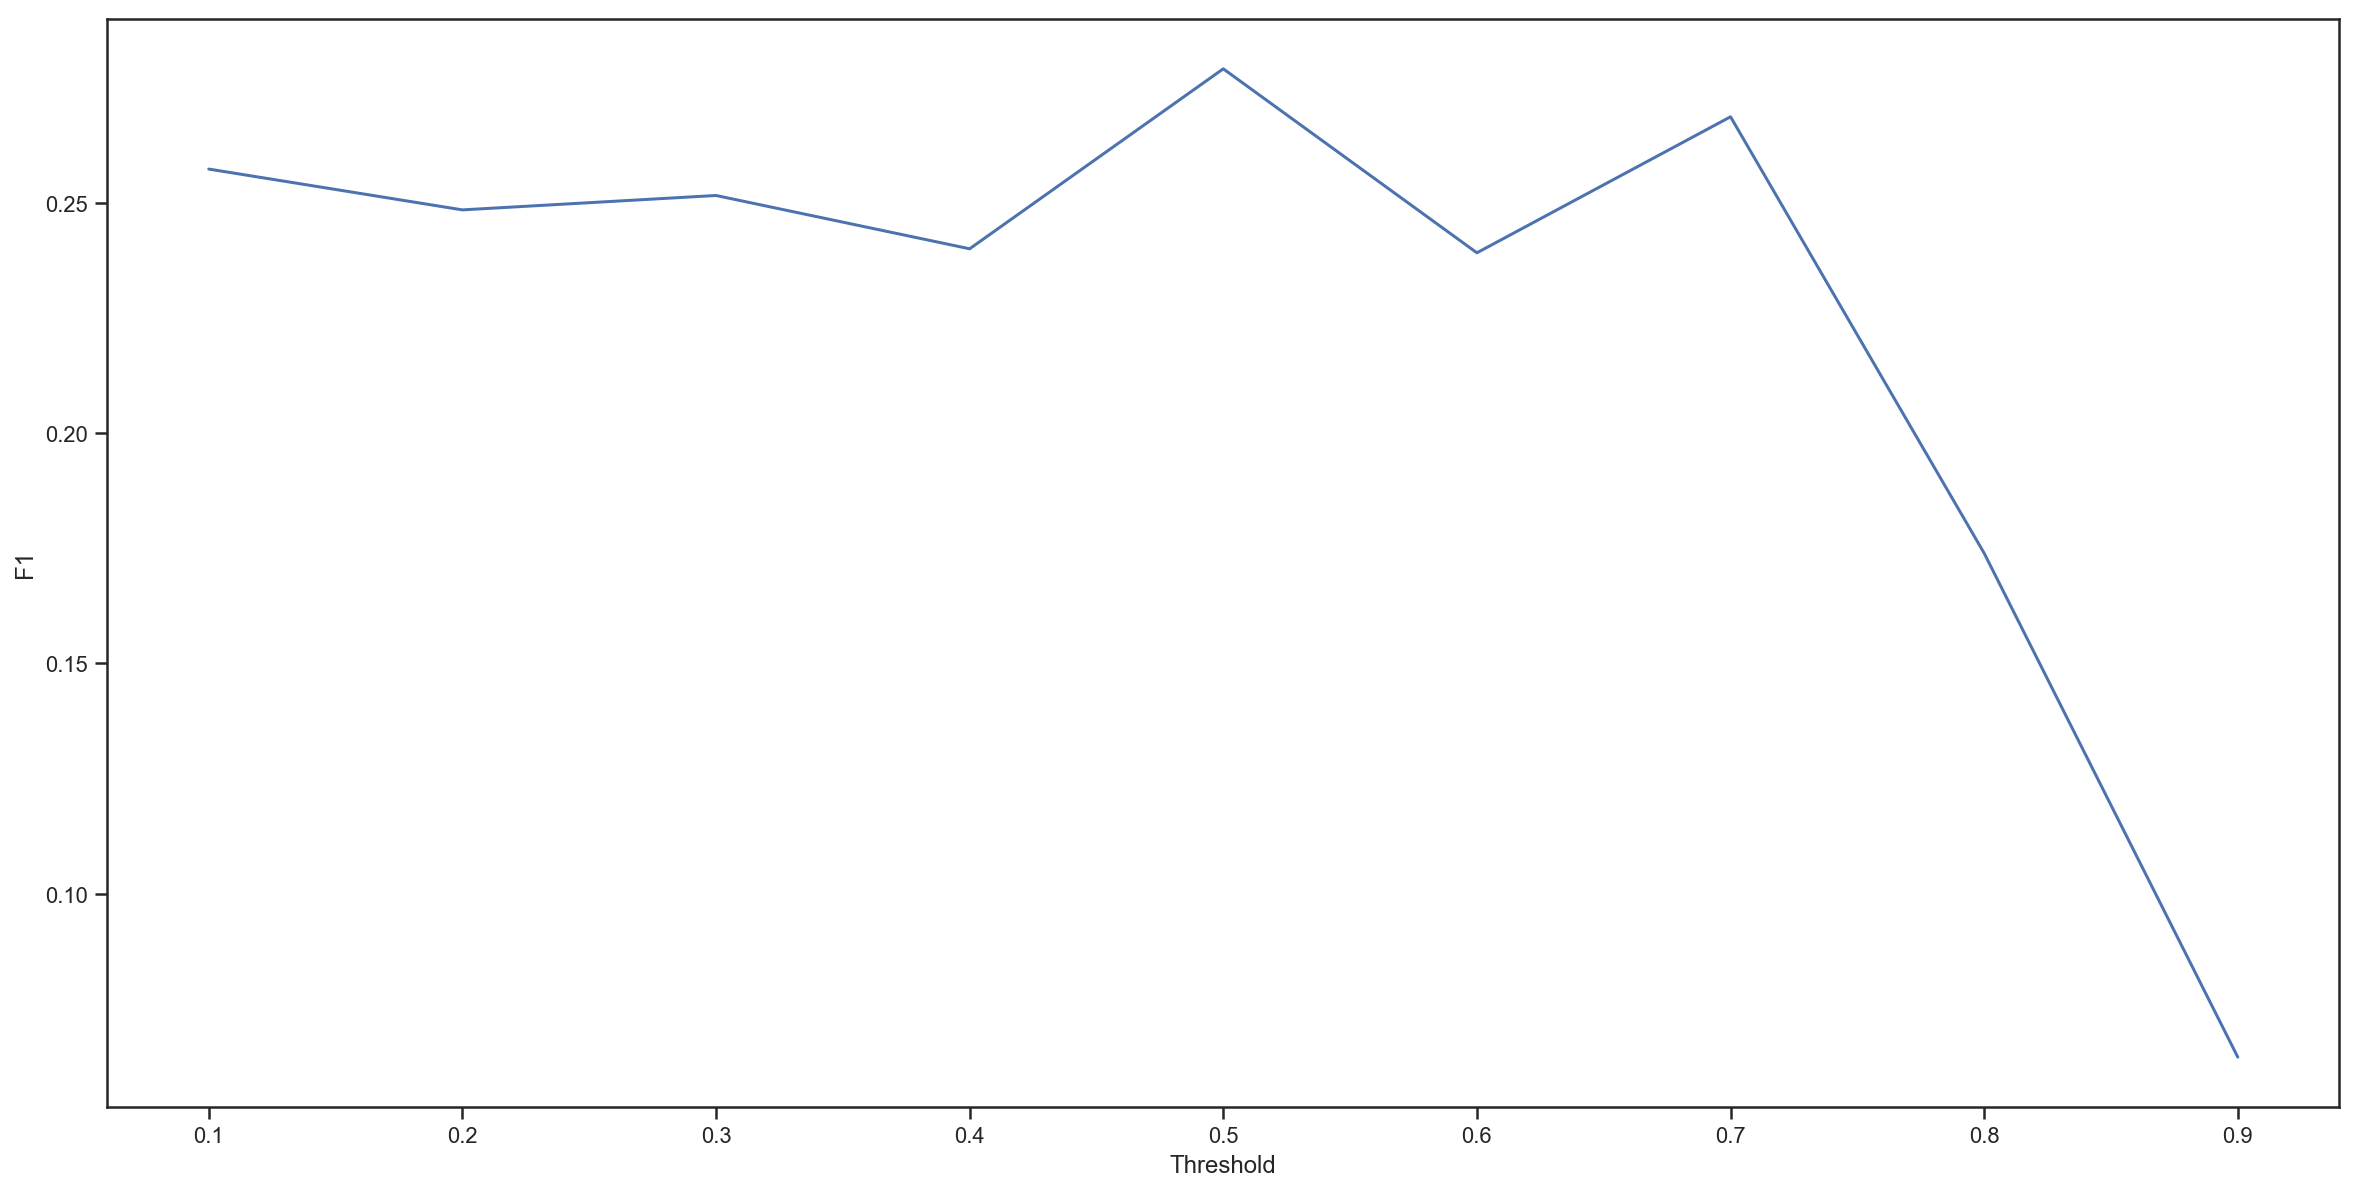

In [120]:
evaluate(predictions5)

---

## Weekly Seasonality + US Holidays

In [121]:
m6 = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
m6.add_country_holidays(country_name="US")

In [122]:
m6.fit(train_df[["ds", "y"]])

In [123]:
predictions6 = m6.predict(test_df[["ds", "y"]])
scaler = MinMaxScaler()
predictions6["yhat"] = scaler.fit_transform(predictions6[["yhat"]])
# predictions6["yhat"].describe()

In [124]:
predictions6 = predictions6.merge(test_df, on=["ds"])

Pearson = 0.04607290029061185
Best F1 = 0.2727272727272727
Precision = 0.20930232558139536
Recall = 0.391304347826087
Threshold = 0.8


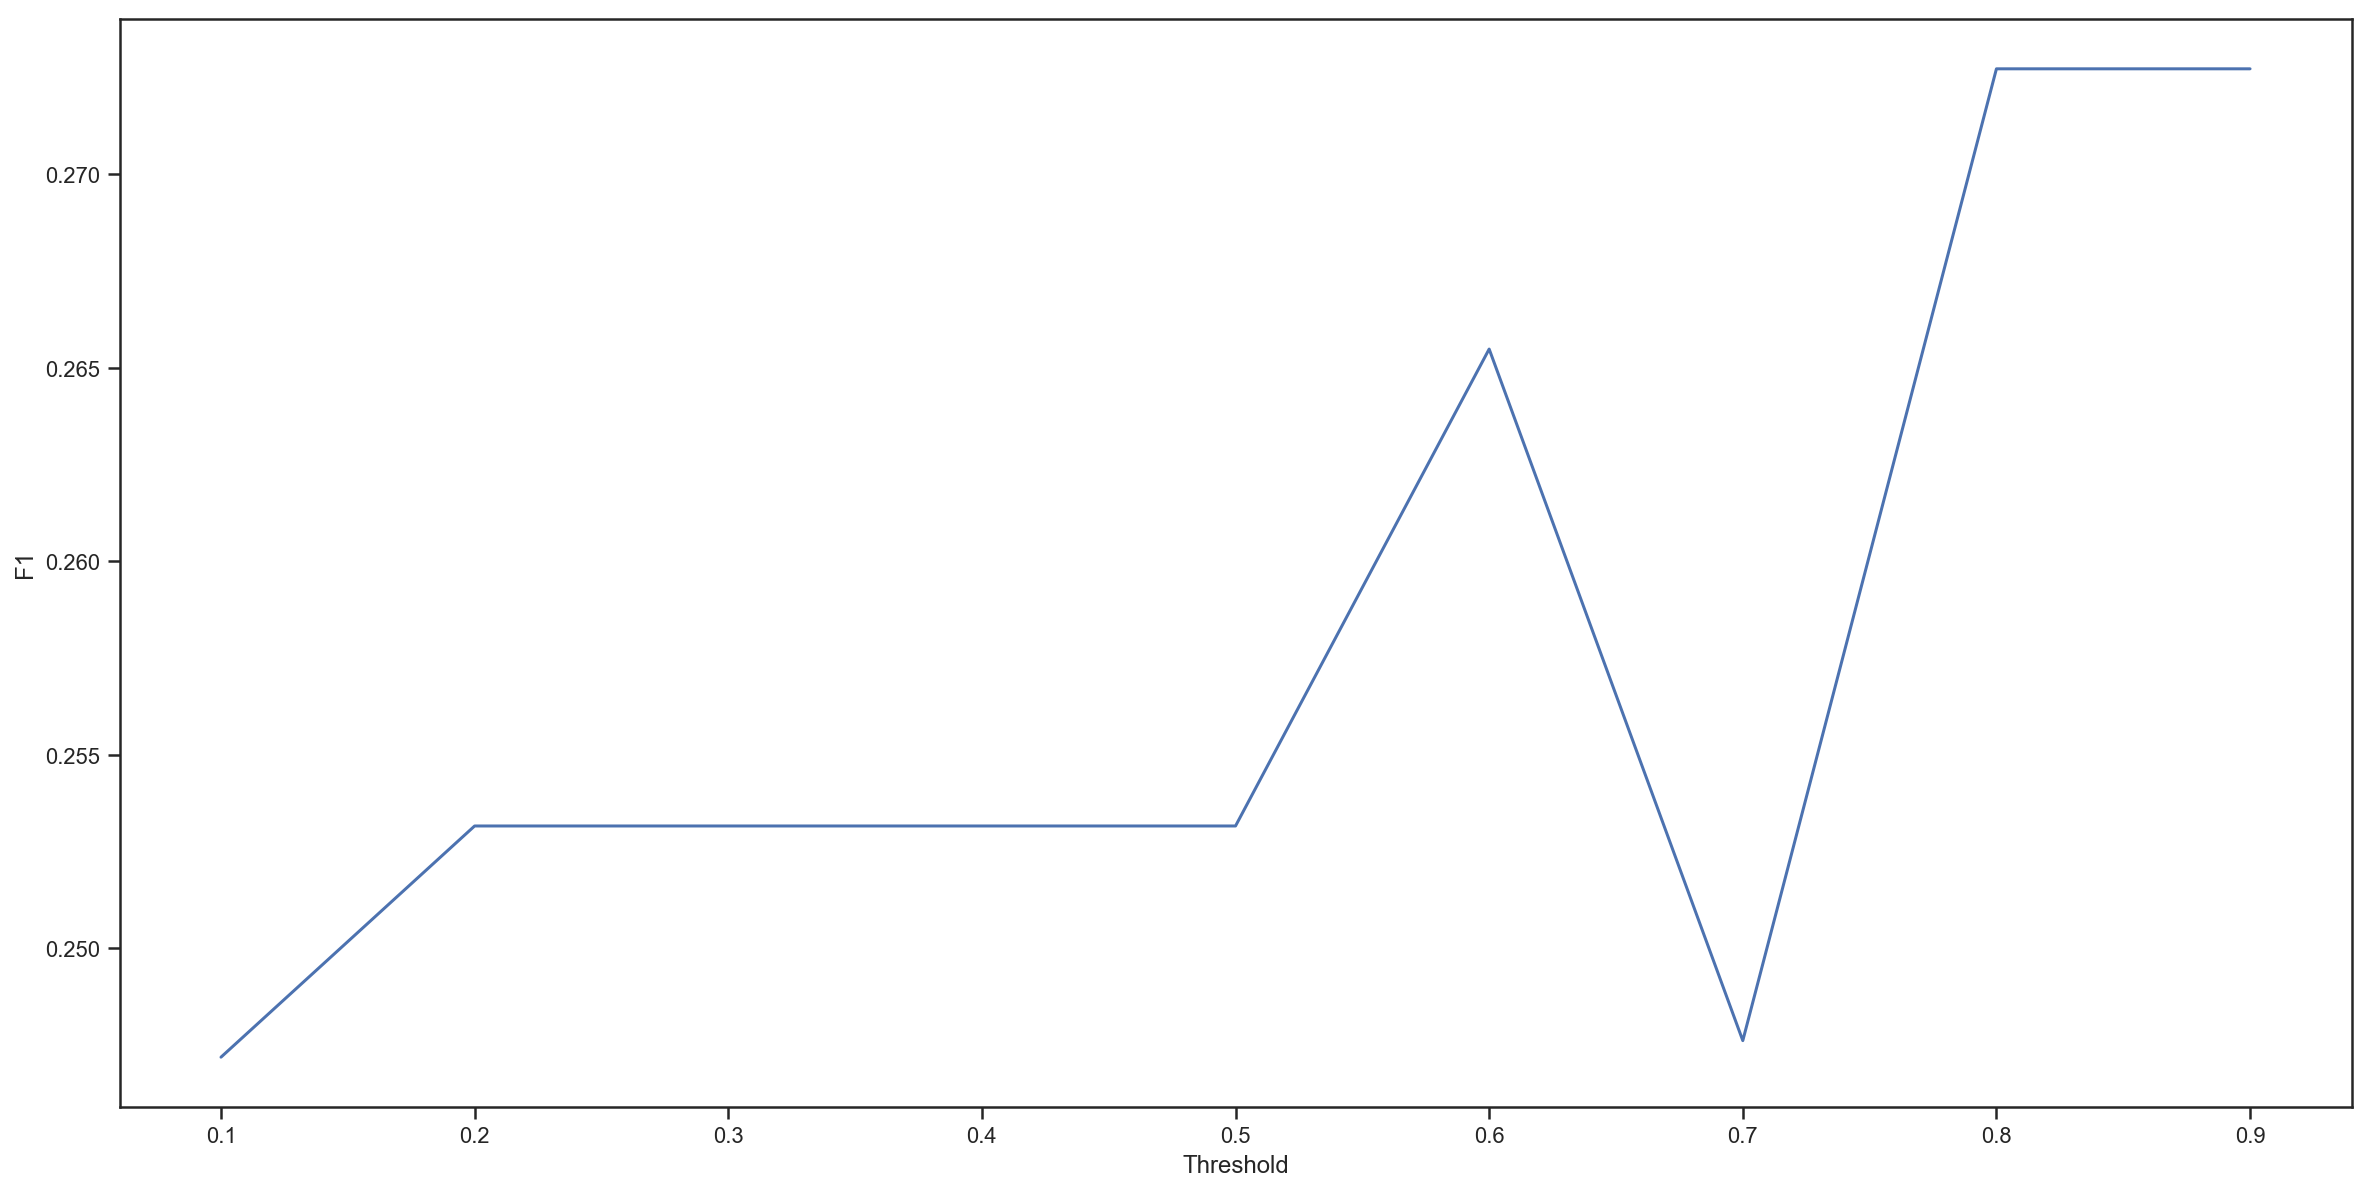

In [125]:
evaluate(predictions6)

---

## Weekly Seasonality + Days Since Previous Release

In [126]:
m7 = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
m7.add_regressor("days_since_previous_release")

In [127]:
m7.fit(train_df[["ds", "days_since_previous_release", "y"]])

In [128]:
predictions7 = m7.predict(test_df[["ds", "days_since_previous_release", "y"]])
scaler = MinMaxScaler()
predictions7["yhat"] = scaler.fit_transform(predictions7[["yhat"]])
# predictions7["yhat"].describe()

In [129]:
predictions7 = predictions7.merge(test_df, on=["ds"])

Pearson = 0.25165688454713736
Best F1 = 0.3466666666666667
Precision = 0.25
Recall = 0.5652173913043478
Threshold = 0.4


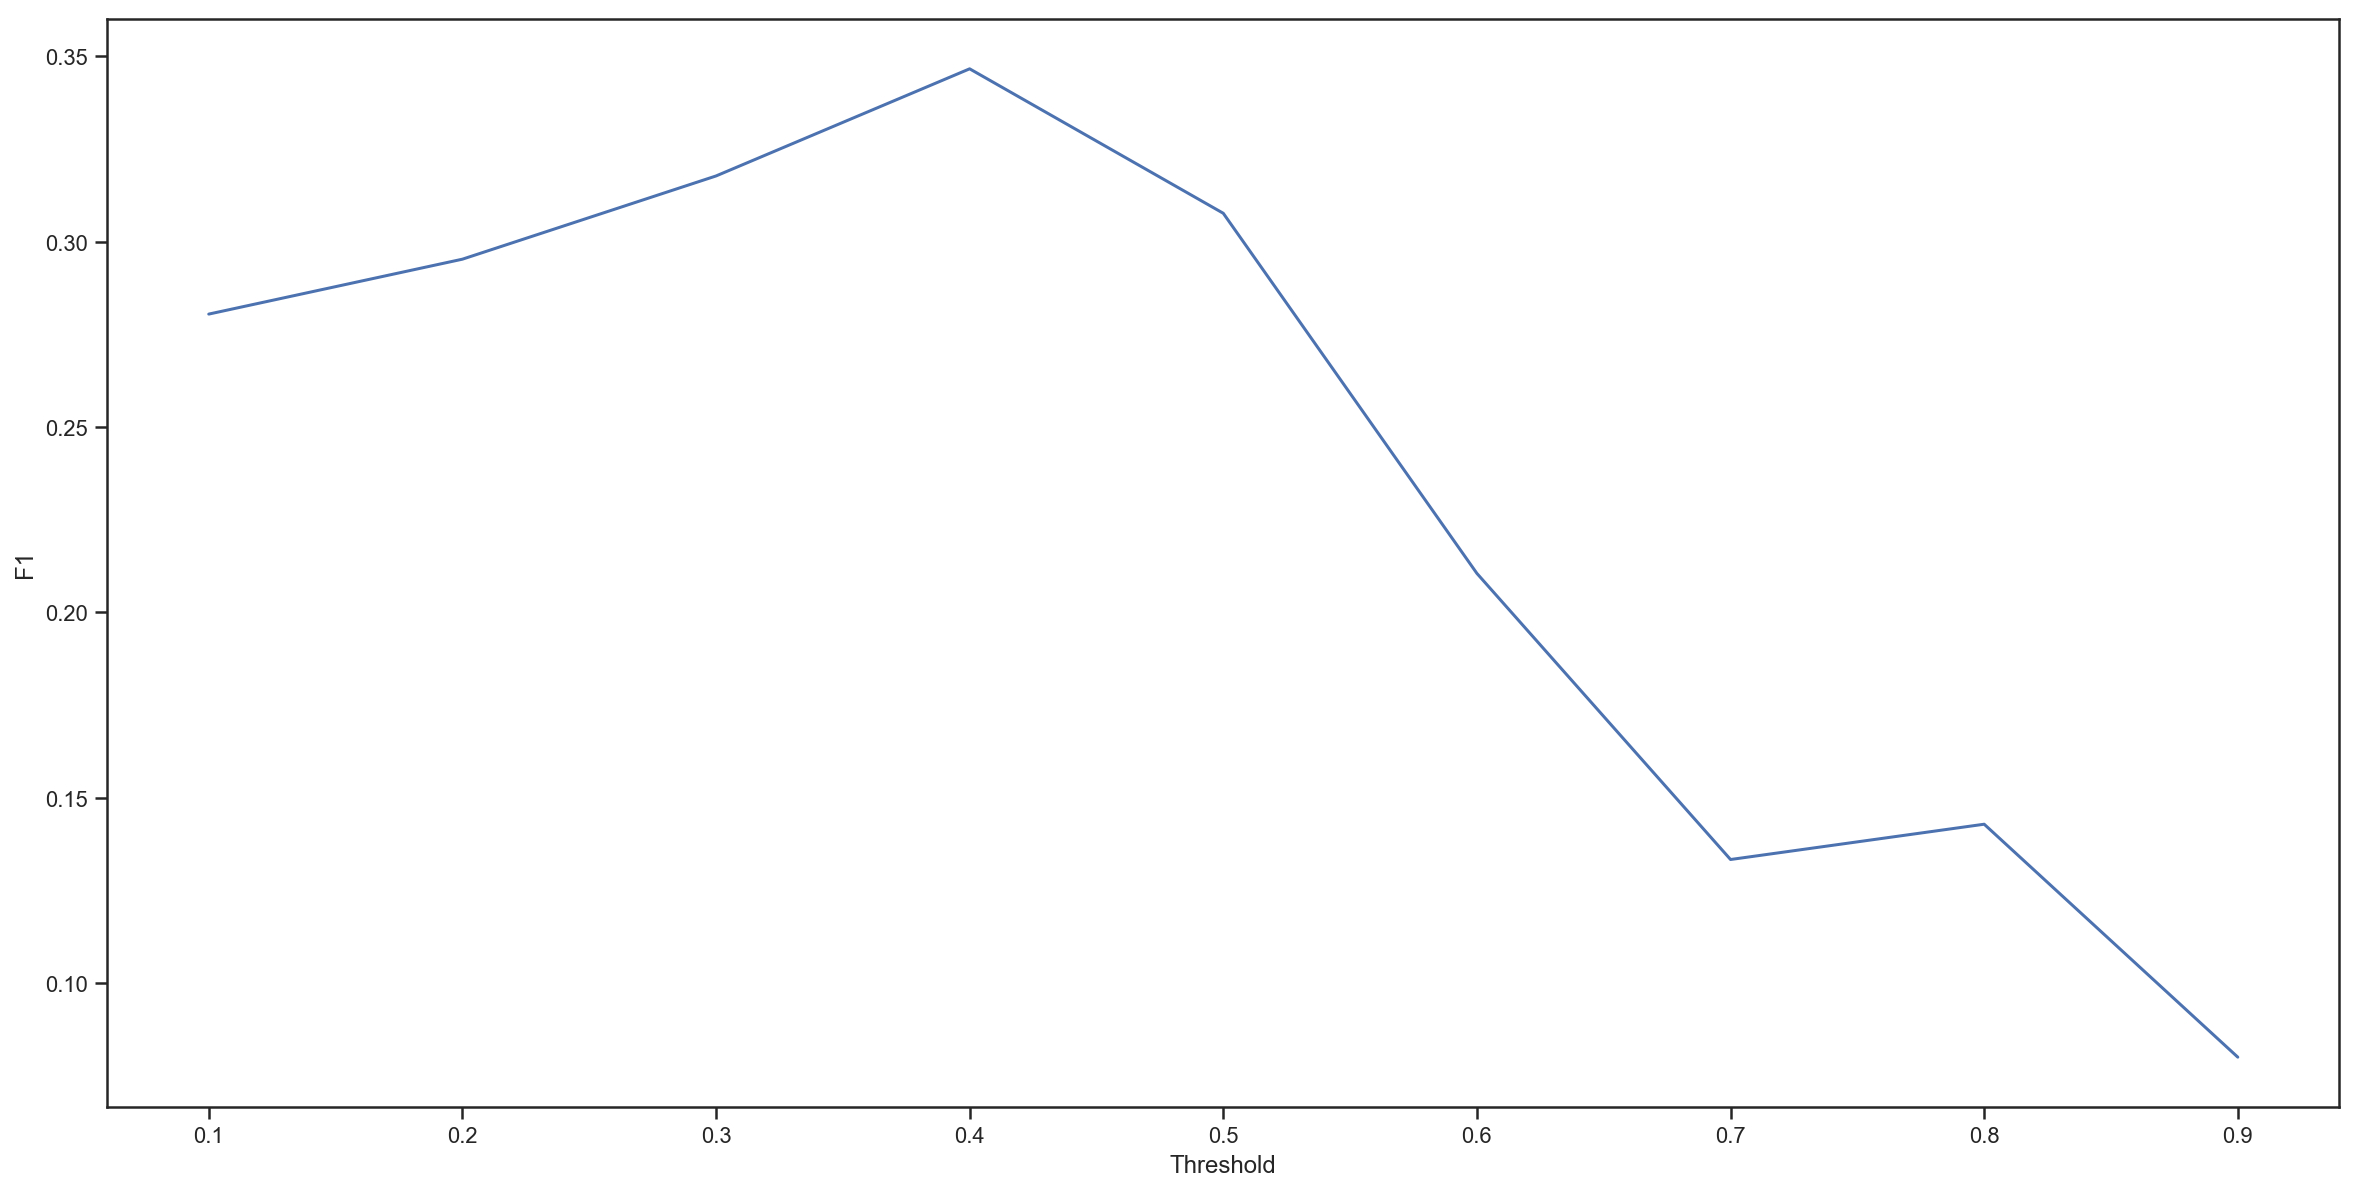

In [130]:
evaluate(predictions7)

---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release

In [131]:
m8 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m8.add_regressor("days_since_previous_release")

In [132]:
m8.fit(train_df[["ds", "days_since_previous_release", "y"]])

In [133]:
predictions8 = m8.predict(test_df[["ds", "days_since_previous_release", "y"]])
scaler = MinMaxScaler()
predictions8["yhat"] = scaler.fit_transform(predictions8[["yhat"]])
# predictions8["yhat"].describe()

In [134]:
predictions8 = predictions8.merge(test_df, on=["ds"])

Pearson = 0.25657990236574646
Best F1 = 0.3529411764705882
Precision = 0.26666666666666666
Recall = 0.5217391304347826
Threshold = 0.5


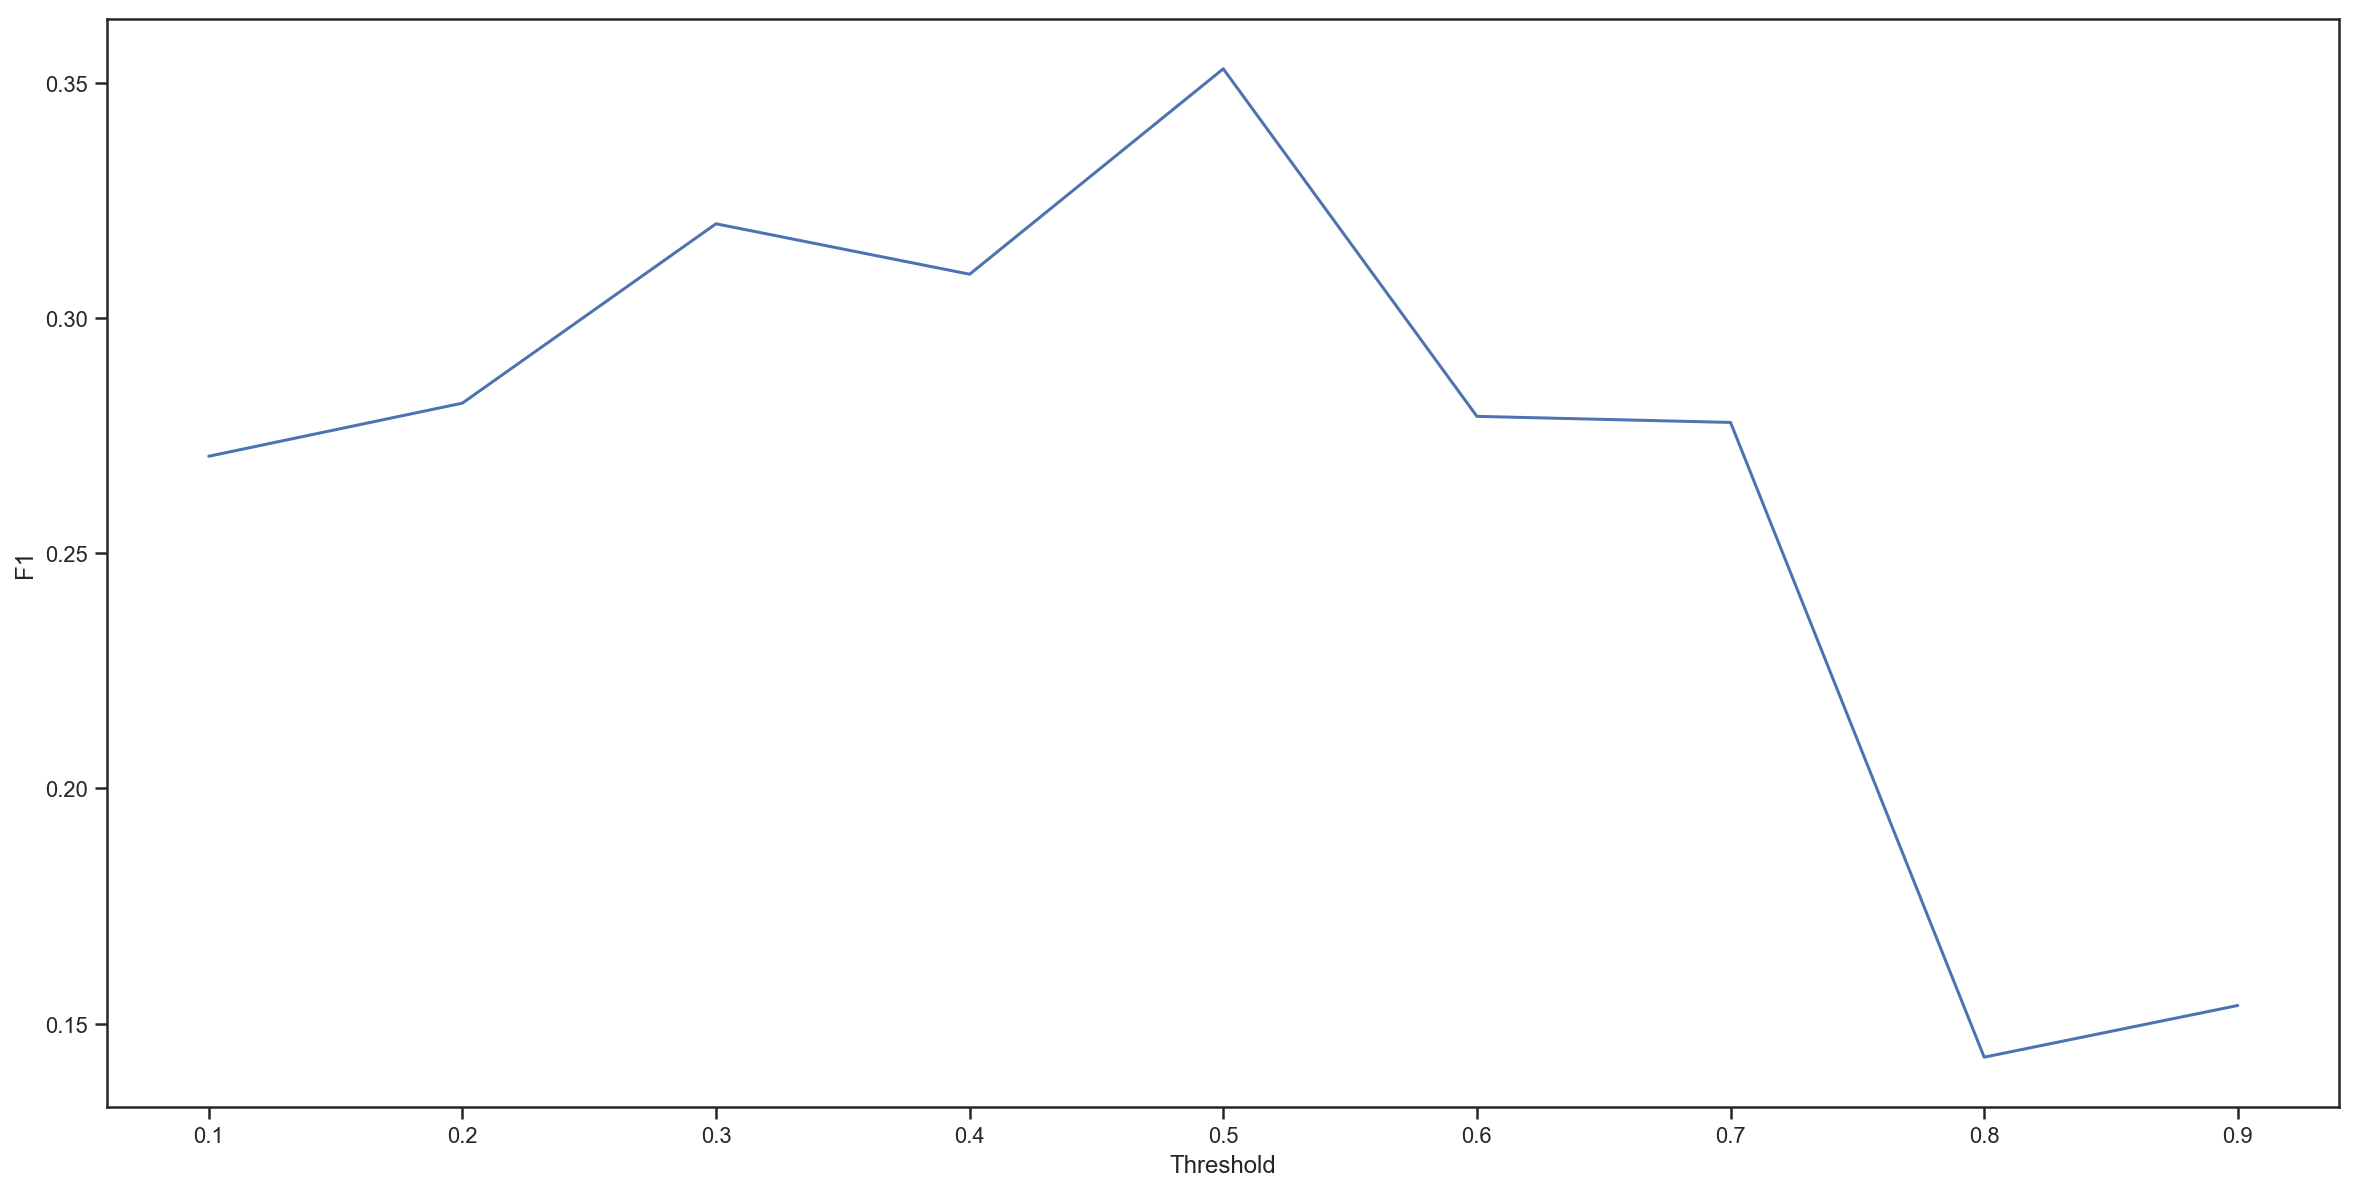

In [135]:
evaluate(predictions8)

In [136]:
# sns.scatterplot(data=predictions8, x="y", y="yhat", hue="y")

In [137]:
# temp = predictions8.copy()
# temp["yhat"] = temp["yhat"].round(2)
# temp = temp.groupby(["y", "yhat"]).size().reset_index()
# sns.lineplot(data=temp, x="yhat", y=0, hue="y")

---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release + Weekday

In [138]:
m9 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m9.add_regressor("days_since_previous_release")
m9.add_regressor("weekday")

In [139]:
m9.fit(train_df[["ds", "days_since_previous_release", "weekday", "y"]])

In [140]:
predictions9 = m9.predict(test_df[["ds", "days_since_previous_release", "weekday", "y"]])
scaler = MinMaxScaler()
predictions9["yhat"] = scaler.fit_transform(predictions9[["yhat"]])
# predictions9["yhat"].describe()

In [141]:
predictions9 = predictions9.merge(test_df, on=["ds"])

Pearson = 0.256663111933266
Best F1 = 0.3582089552238806
Precision = 0.2727272727272727
Recall = 0.5217391304347826
Threshold = 0.5


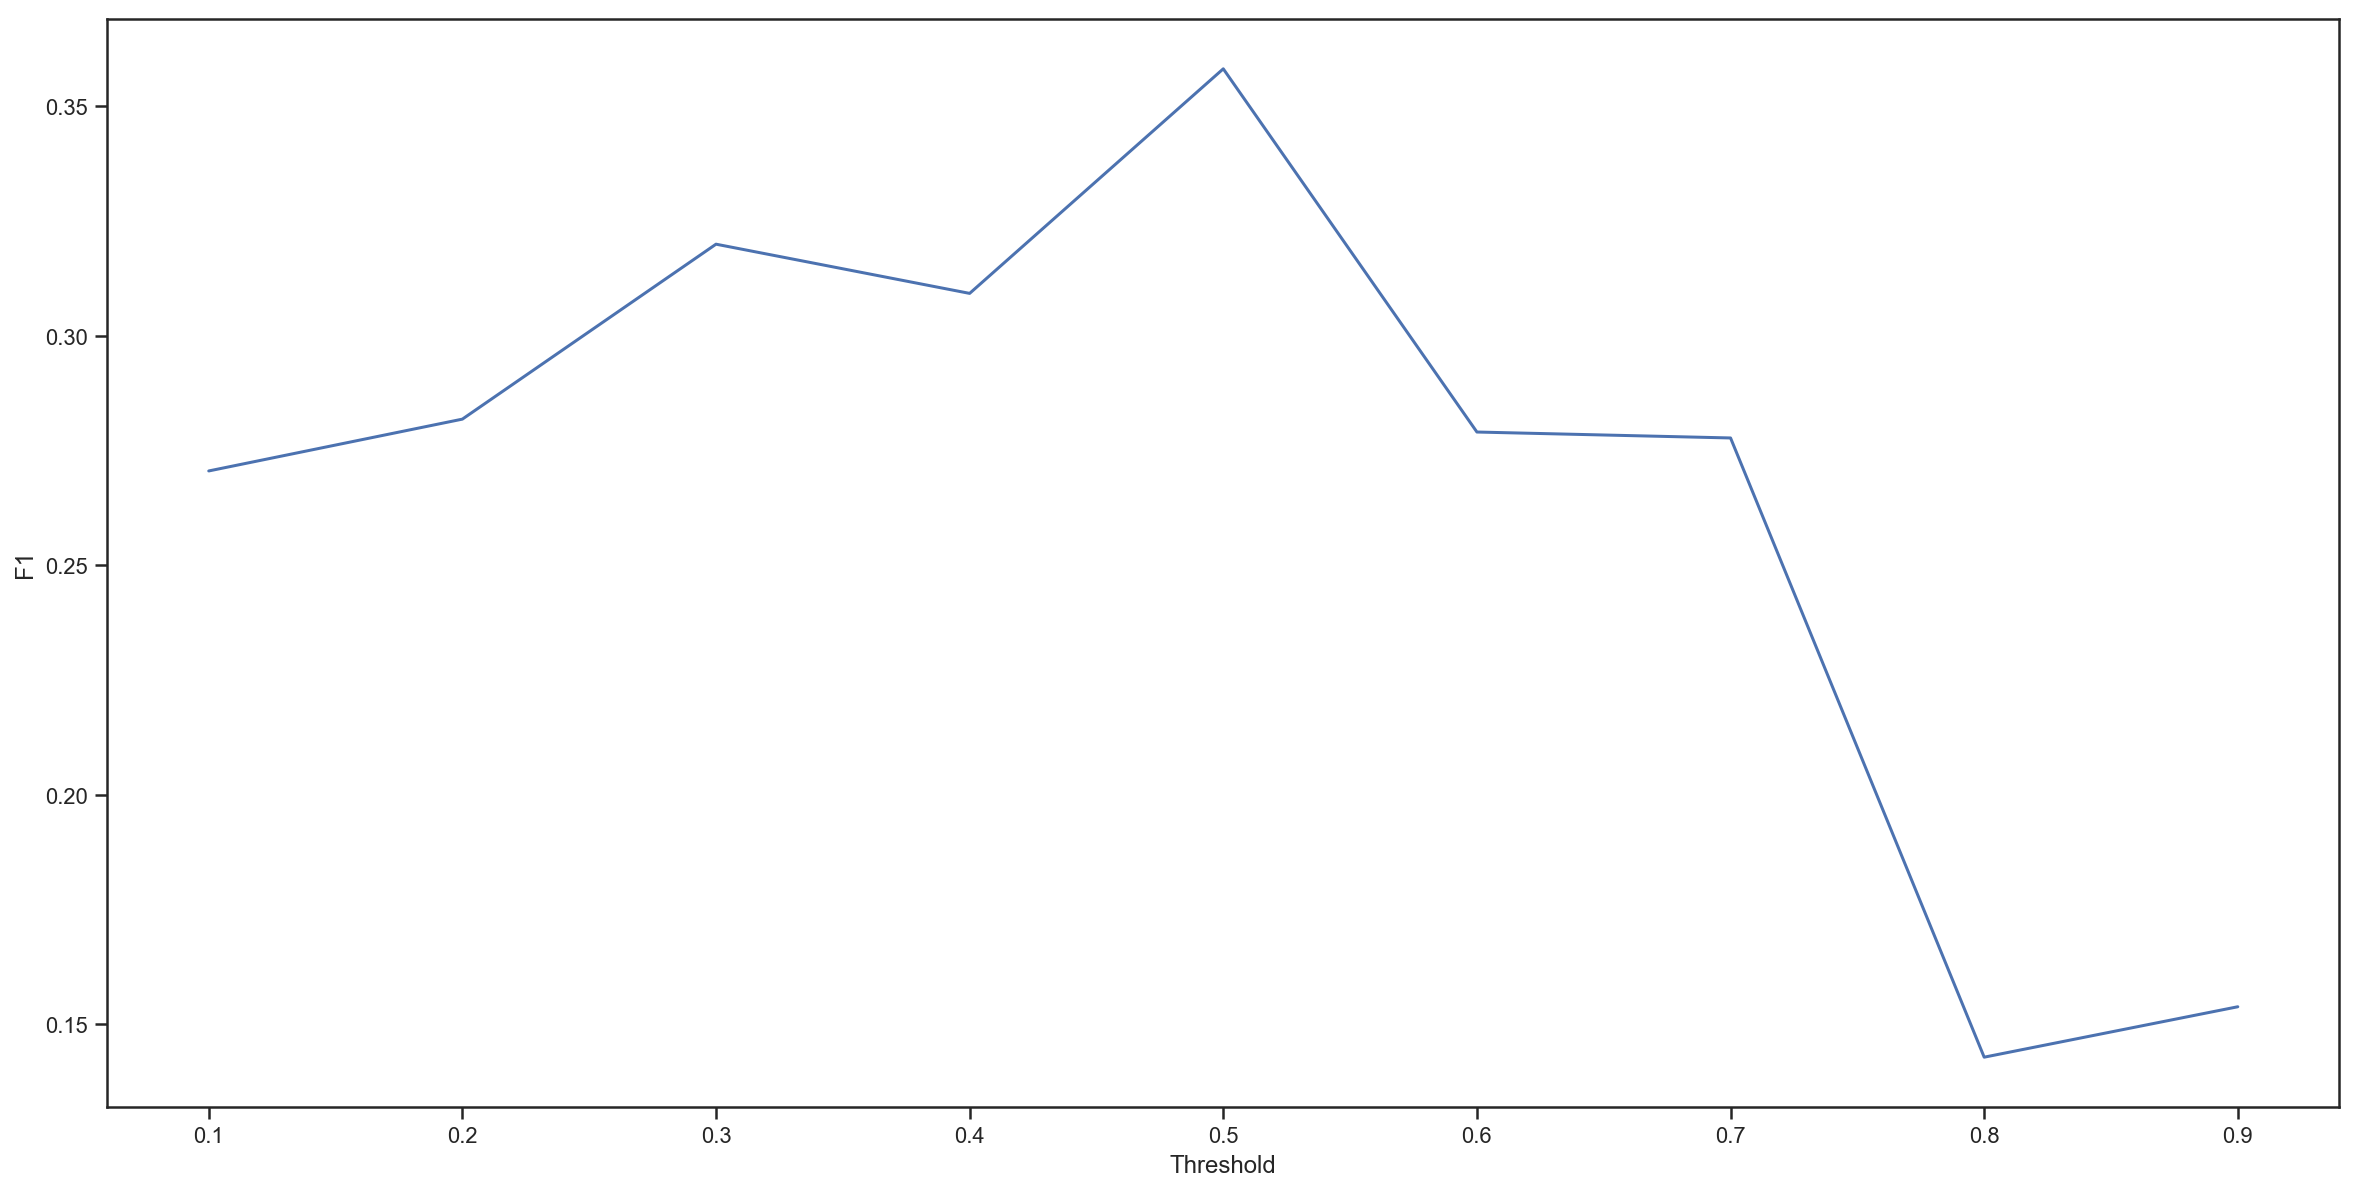

In [142]:
evaluate(predictions9)

---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release + Weekday + US Holidays

In [143]:
m10 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m10.add_regressor("days_since_previous_release")
m10.add_regressor("weekday")
m10.add_country_holidays(country_name="US")

In [144]:
m10.fit(train_df[["ds", "days_since_previous_release", "weekday", "y"]])

In [145]:
predictions10 = m10.predict(test_df[["ds", "days_since_previous_release", "weekday", "y"]])
scaler = MinMaxScaler()
predictions10["yhat"] = scaler.fit_transform(predictions10[["yhat"]])
# predictions10["yhat"].describe()

In [146]:
predictions10 = predictions10.merge(test_df, on=["ds"])

Pearson = 0.25806377544797987
Best F1 = 0.3529411764705882
Precision = 0.26666666666666666
Recall = 0.5217391304347826
Threshold = 0.5


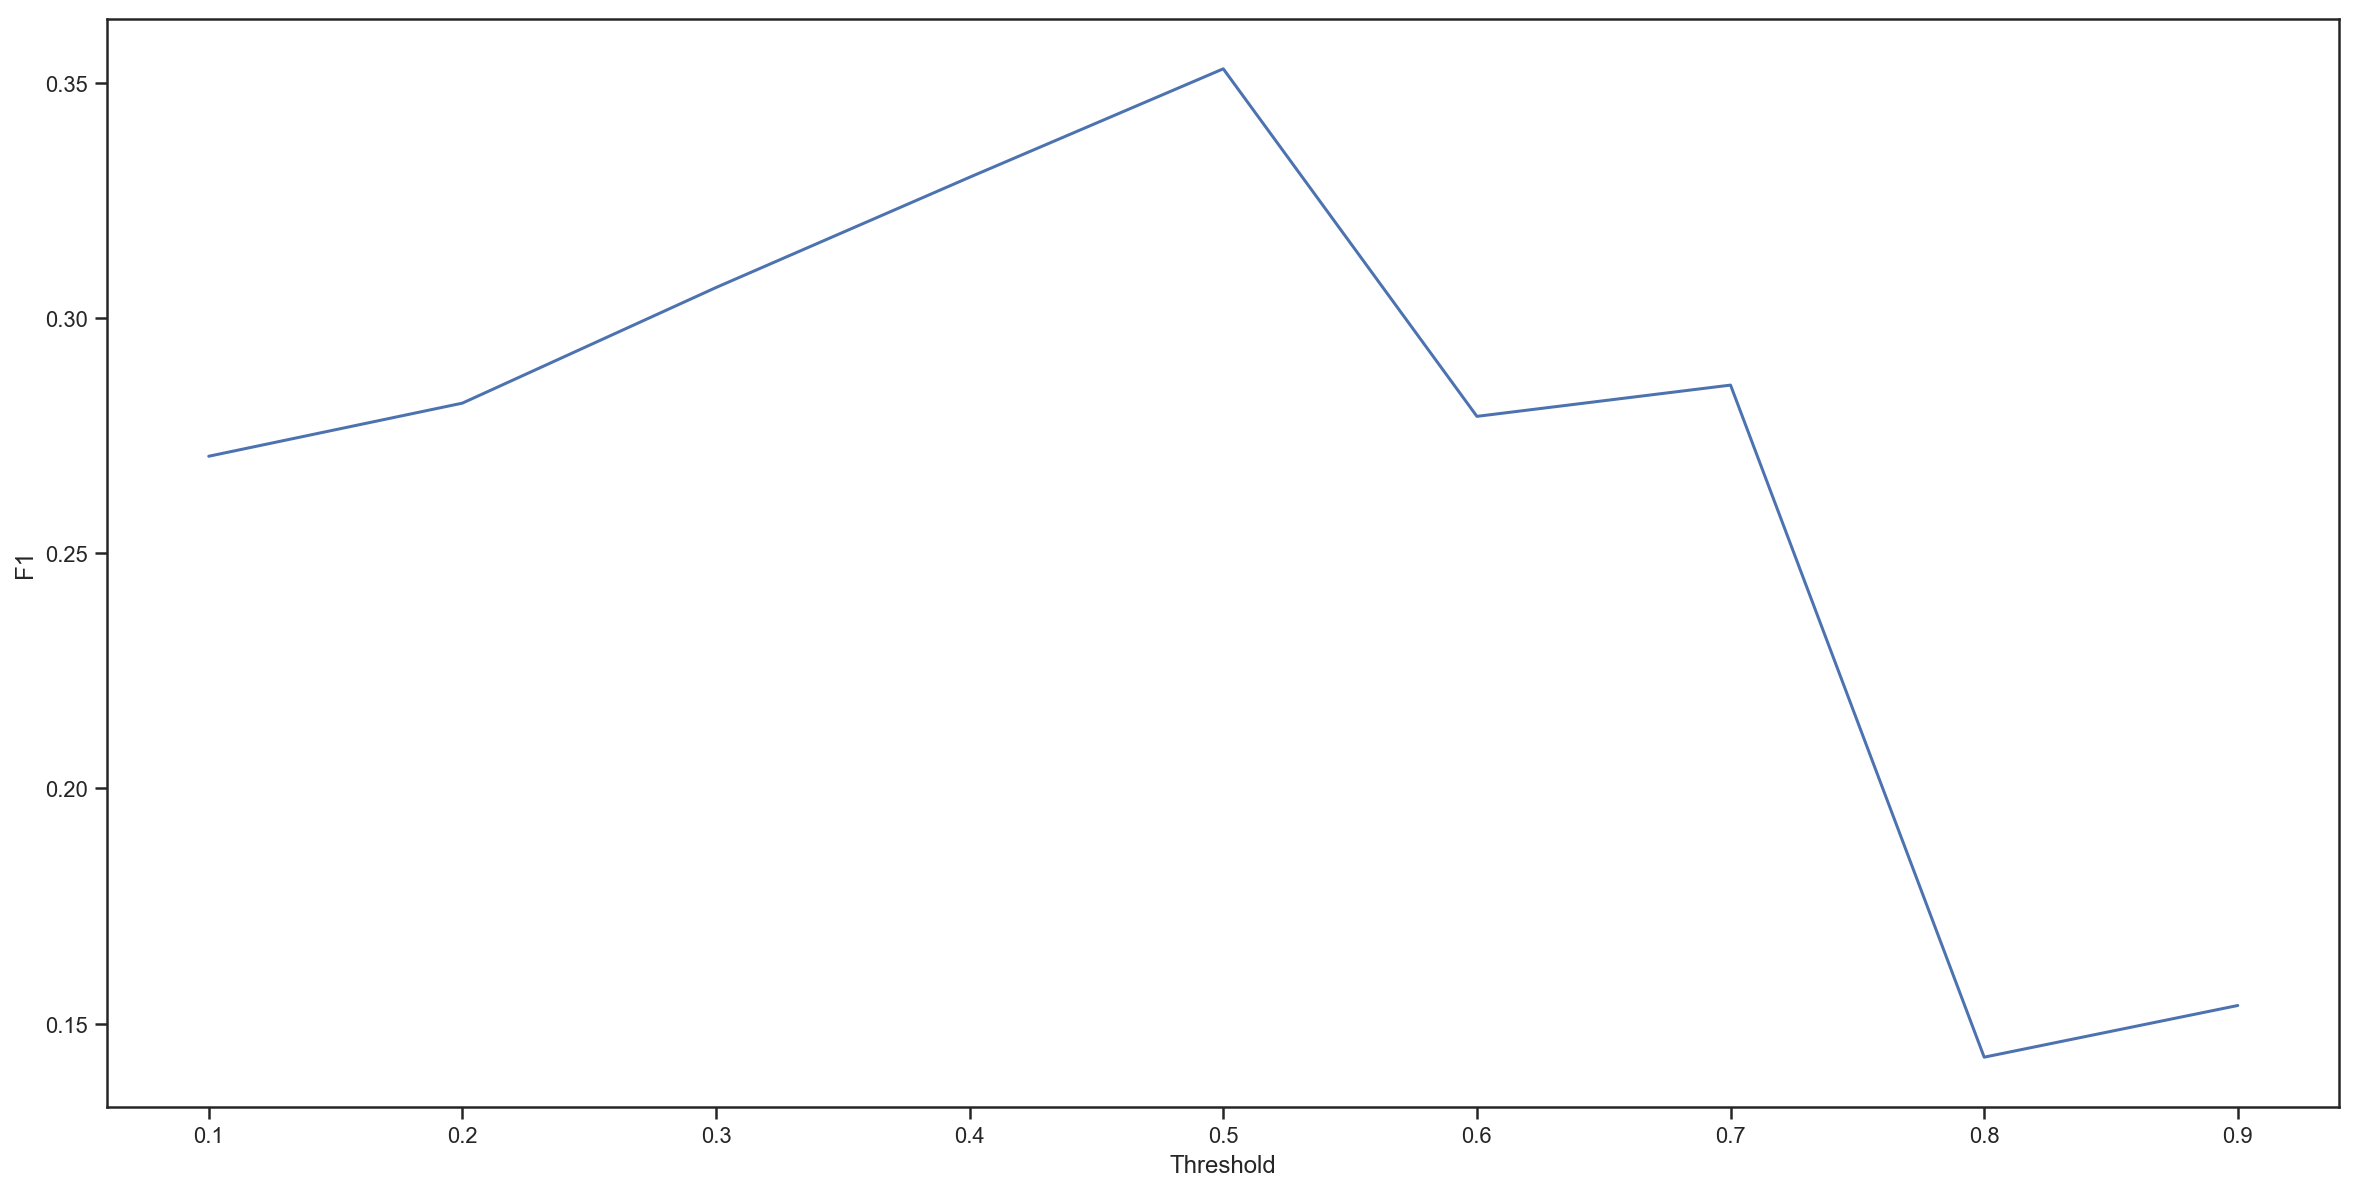

In [147]:
evaluate(predictions10)

In [148]:
# sns.scatterplot(data=predictions10, x="ds", y="yhat", hue="y")

---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release + Weekday + US Holidays + Multiplicative Seasonality

In [149]:
m11 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, 
              seasonality_mode="multiplicative")
m11.add_regressor("days_since_previous_release")
m11.add_regressor("weekday")
m11.add_country_holidays(country_name="US")

In [150]:
m11.fit(train_df[["ds", "days_since_previous_release", "weekday", "y"]])

In [151]:
predictions11 = m11.predict(test_df[["ds", "days_since_previous_release", "weekday", "y"]])
scaler = MinMaxScaler()
predictions11["yhat"] = scaler.fit_transform(predictions11[["yhat"]])
# predictions11["yhat"].describe()

In [152]:
predictions11 = predictions11.merge(test_df, on=["ds"])

Pearson = 0.259594340646778
Best F1 = 0.37333333333333335
Precision = 0.2692307692307692
Recall = 0.6086956521739131
Threshold = 0.5


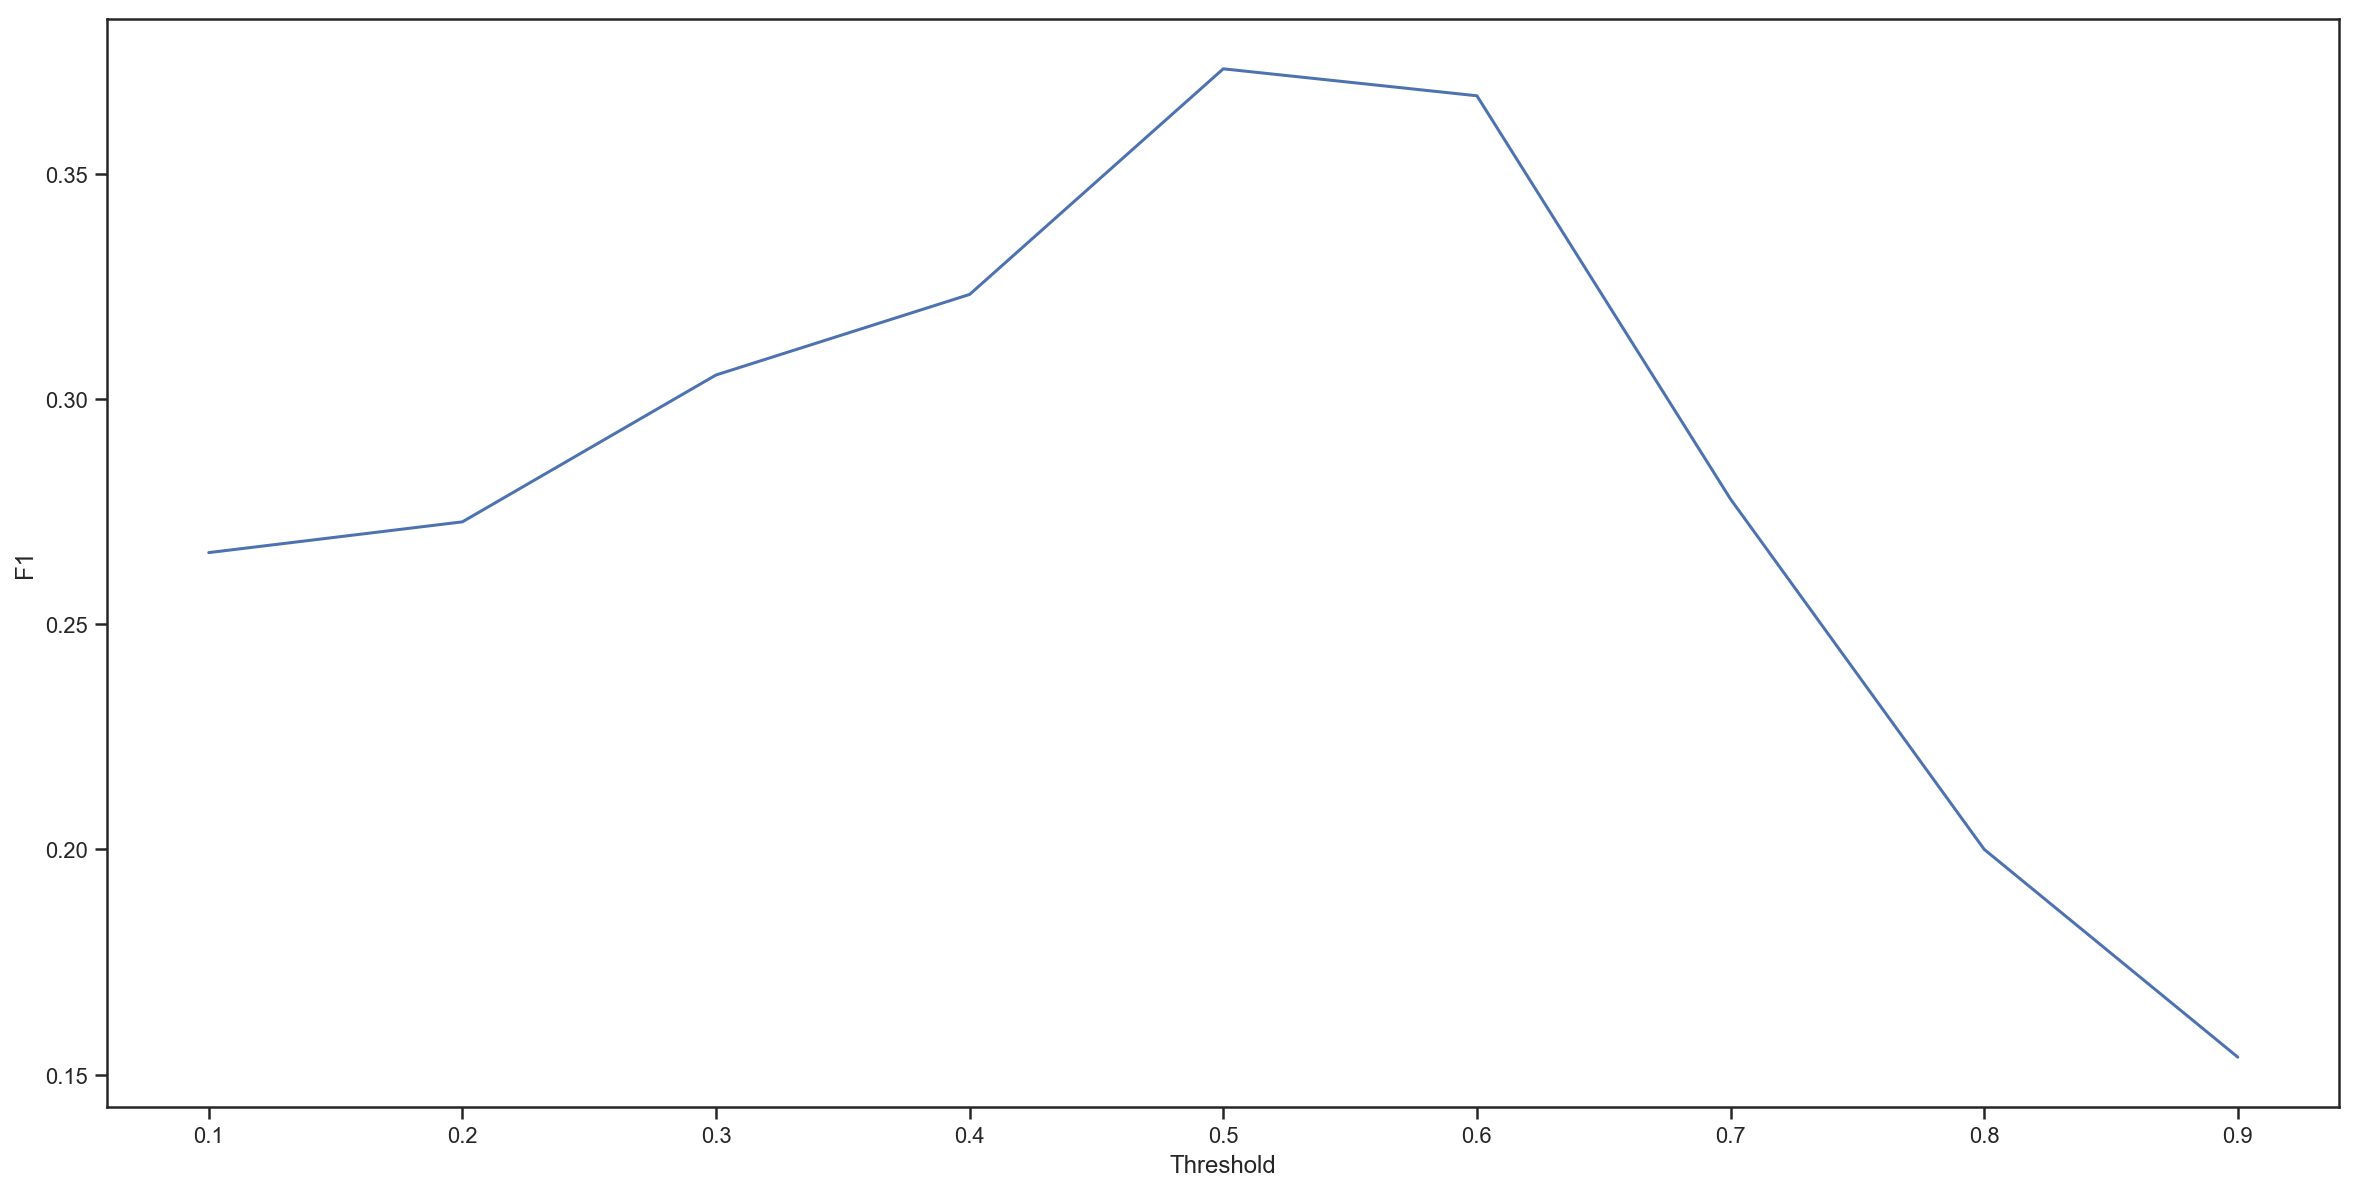

In [153]:
evaluate(predictions11)

---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release + Weekday + US Holidays + Seasonality Prior Scale Increase

In [154]:
m12 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, 
              seasonality_prior_scale=100)
m12.add_regressor("days_since_previous_release")
m12.add_regressor("weekday")
m12.add_country_holidays(country_name="US")

In [155]:
m12.fit(train_df[["ds", "days_since_previous_release", "weekday", "y"]])

In [156]:
predictions12 = m12.predict(test_df[["ds", "days_since_previous_release", "weekday", "y"]])
scaler = MinMaxScaler()
predictions12["yhat"] = scaler.fit_transform(predictions12[["yhat"]])
# predictions12["yhat"].describe()

In [157]:
predictions12 = predictions12.merge(test_df, on=["ds"])

Pearson = 0.25823345978765017
Best F1 = 0.3529411764705882
Precision = 0.26666666666666666
Recall = 0.5217391304347826
Threshold = 0.5


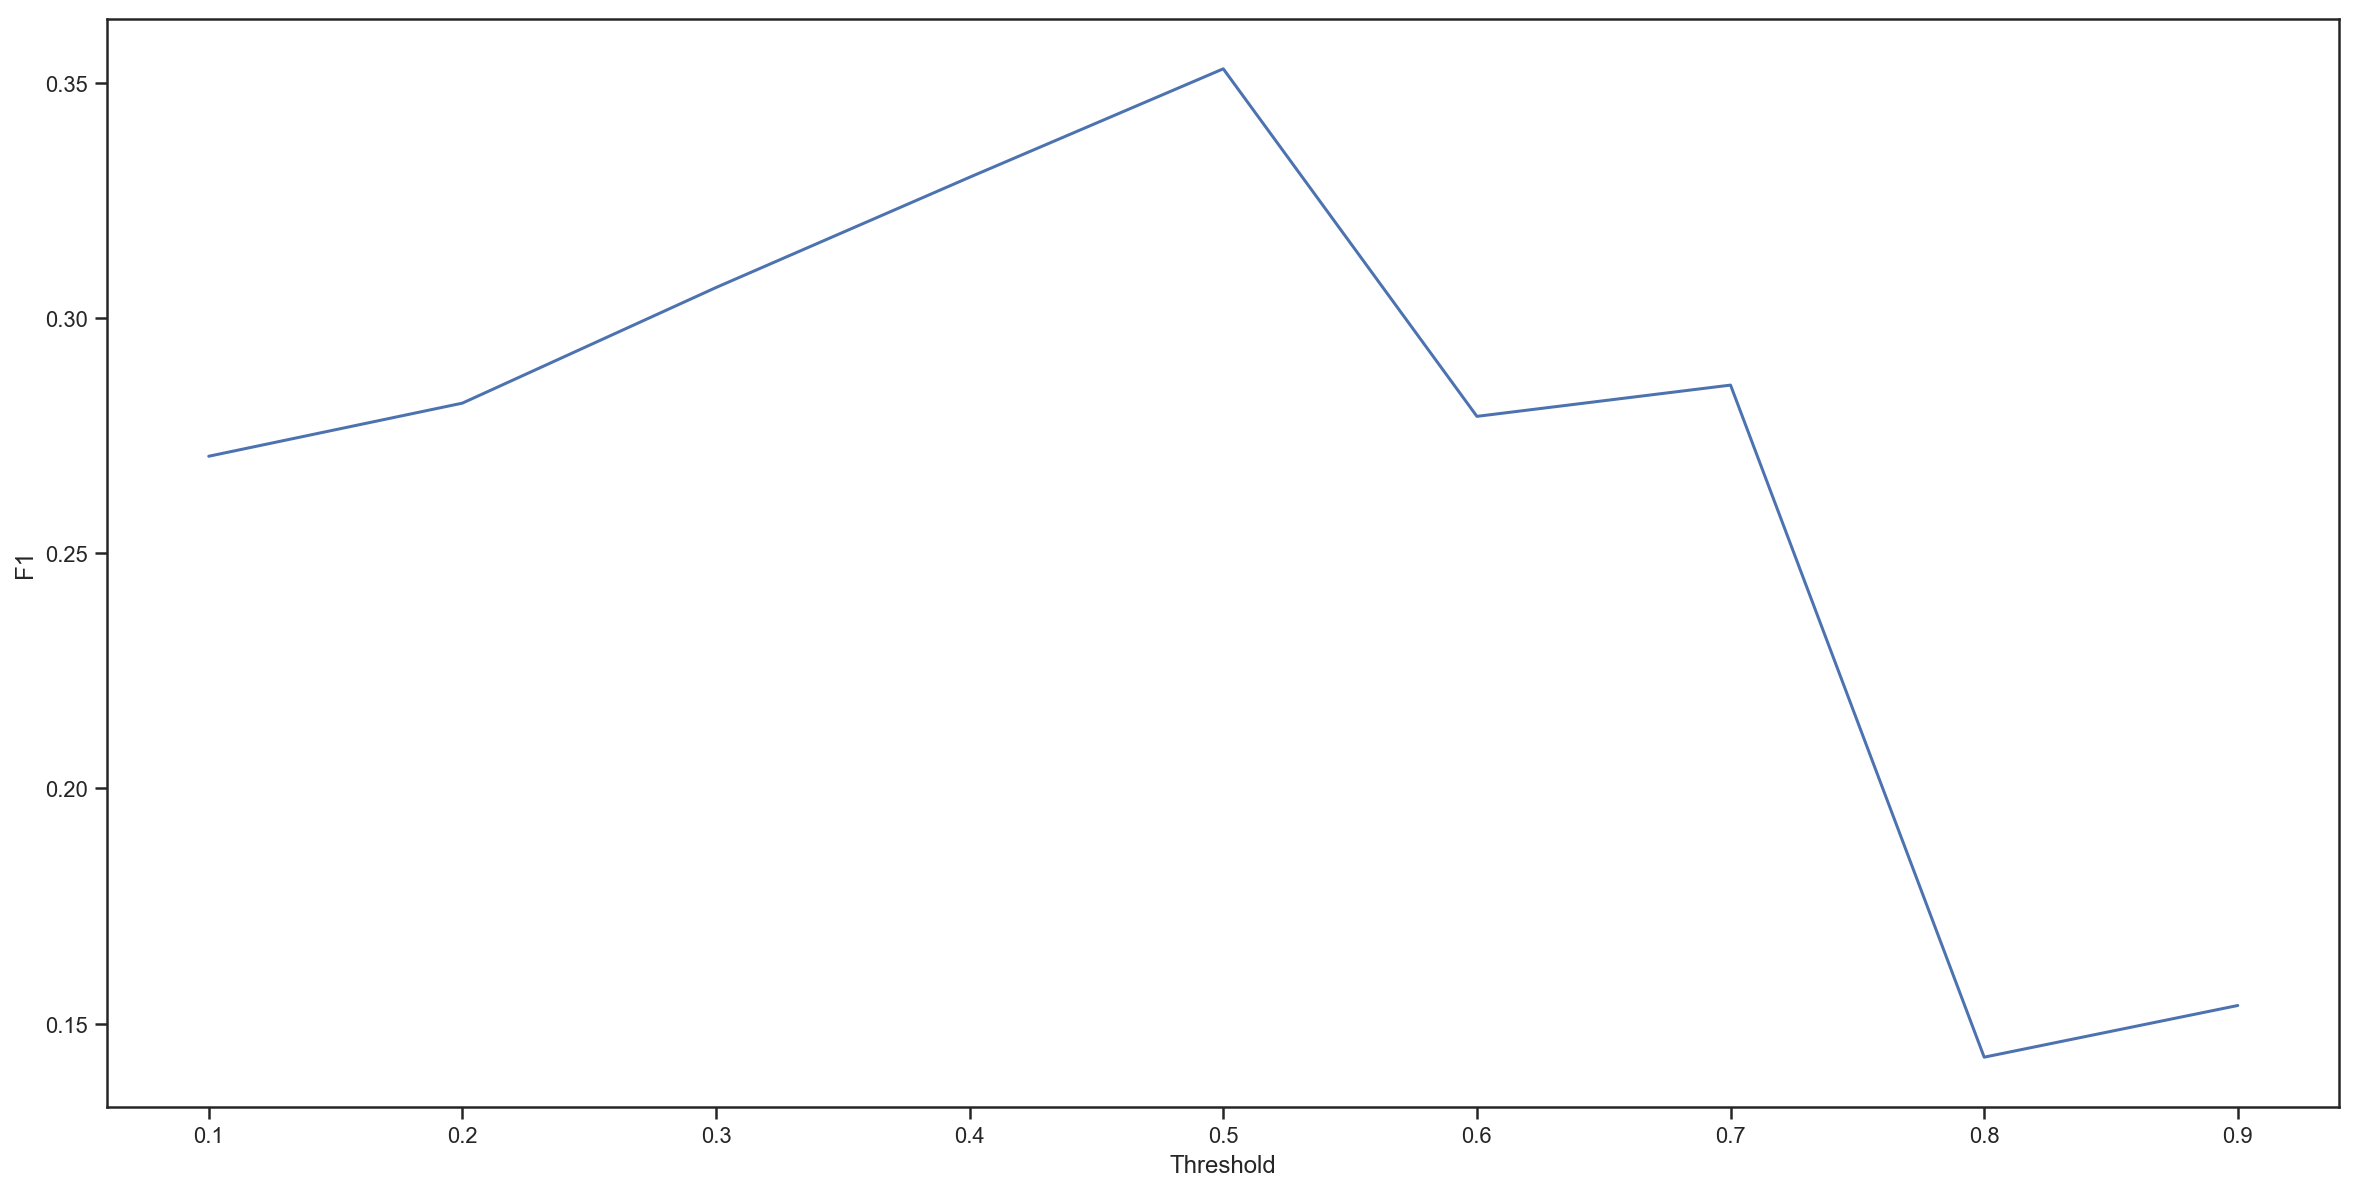

In [158]:
evaluate(predictions12)

---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release + Weekday + US Holidays + Seasonality Prior Scale Increase + Multiplicative Days Since Previous Release

In [159]:
m13 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, 
              seasonality_prior_scale=100)
m13.add_regressor("days_since_previous_release", mode="multiplicative")
m13.add_regressor("weekday")
m13.add_country_holidays(country_name="US")

In [160]:
m13.fit(train_df[["ds", "days_since_previous_release", "weekday", "y"]])

In [161]:
predictions13 = m13.predict(test_df[["ds", "days_since_previous_release", "weekday", "y"]])
scaler = MinMaxScaler()
predictions13["yhat"] = scaler.fit_transform(predictions13[["yhat"]])
# predictions13["yhat"].describe()

In [162]:
predictions13 = predictions13.merge(test_df, on=["ds"])

Pearson = 0.25693918909746044
Best F1 = 0.36363636363636365
Precision = 0.27906976744186046
Recall = 0.5217391304347826
Threshold = 0.5


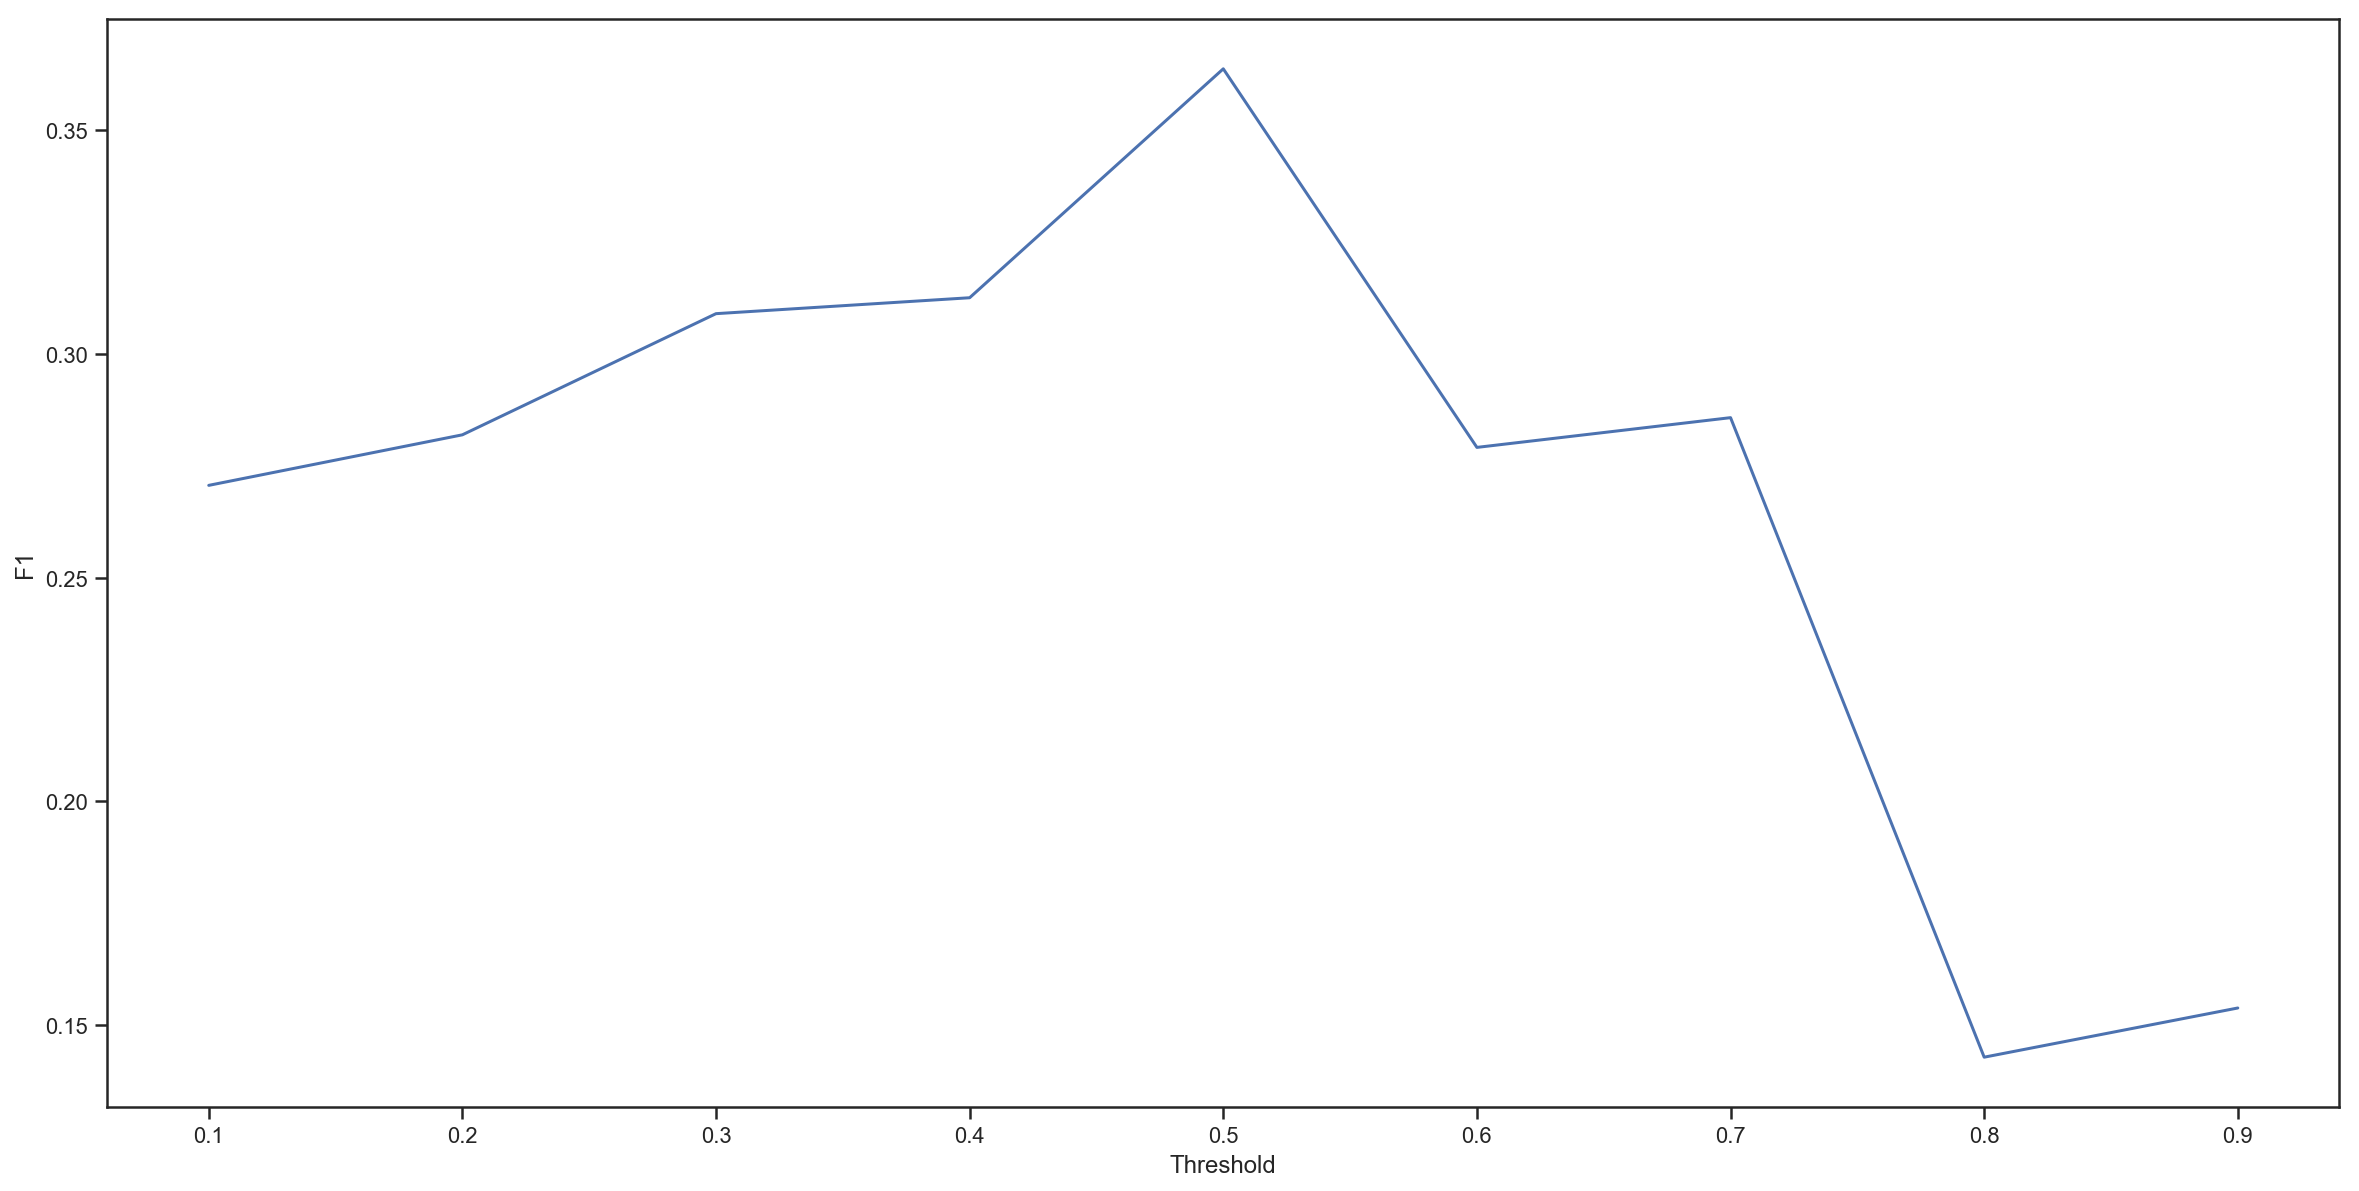

In [163]:
evaluate(predictions13)

---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release + Weekday + US Holidays + Seasonality Prior Scale Increase + Multiplicative Days Since Previous Release + Fourier Terms on Yearly and Weekly Seasonality

In [164]:
m14 = Prophet(yearly_seasonality=10, weekly_seasonality=10, daily_seasonality=False, 
              seasonality_prior_scale=100)
m14.add_regressor("days_since_previous_release", mode="multiplicative")
m14.add_regressor("weekday")
m14.add_country_holidays(country_name="US")

In [165]:
m14.fit(train_df[["ds", "days_since_previous_release", "weekday", "y"]])

In [166]:
predictions14 = m14.predict(test_df[["ds", "days_since_previous_release", "weekday", "y"]])
scaler = MinMaxScaler()
predictions14["yhat"] = scaler.fit_transform(predictions14[["yhat"]])
# predictions14["yhat"].describe()

In [167]:
predictions14 = predictions14.merge(test_df, on=["ds"])

Pearson = 0.2575710945521295
Best F1 = 0.3529411764705882
Precision = 0.26666666666666666
Recall = 0.5217391304347826
Threshold = 0.5


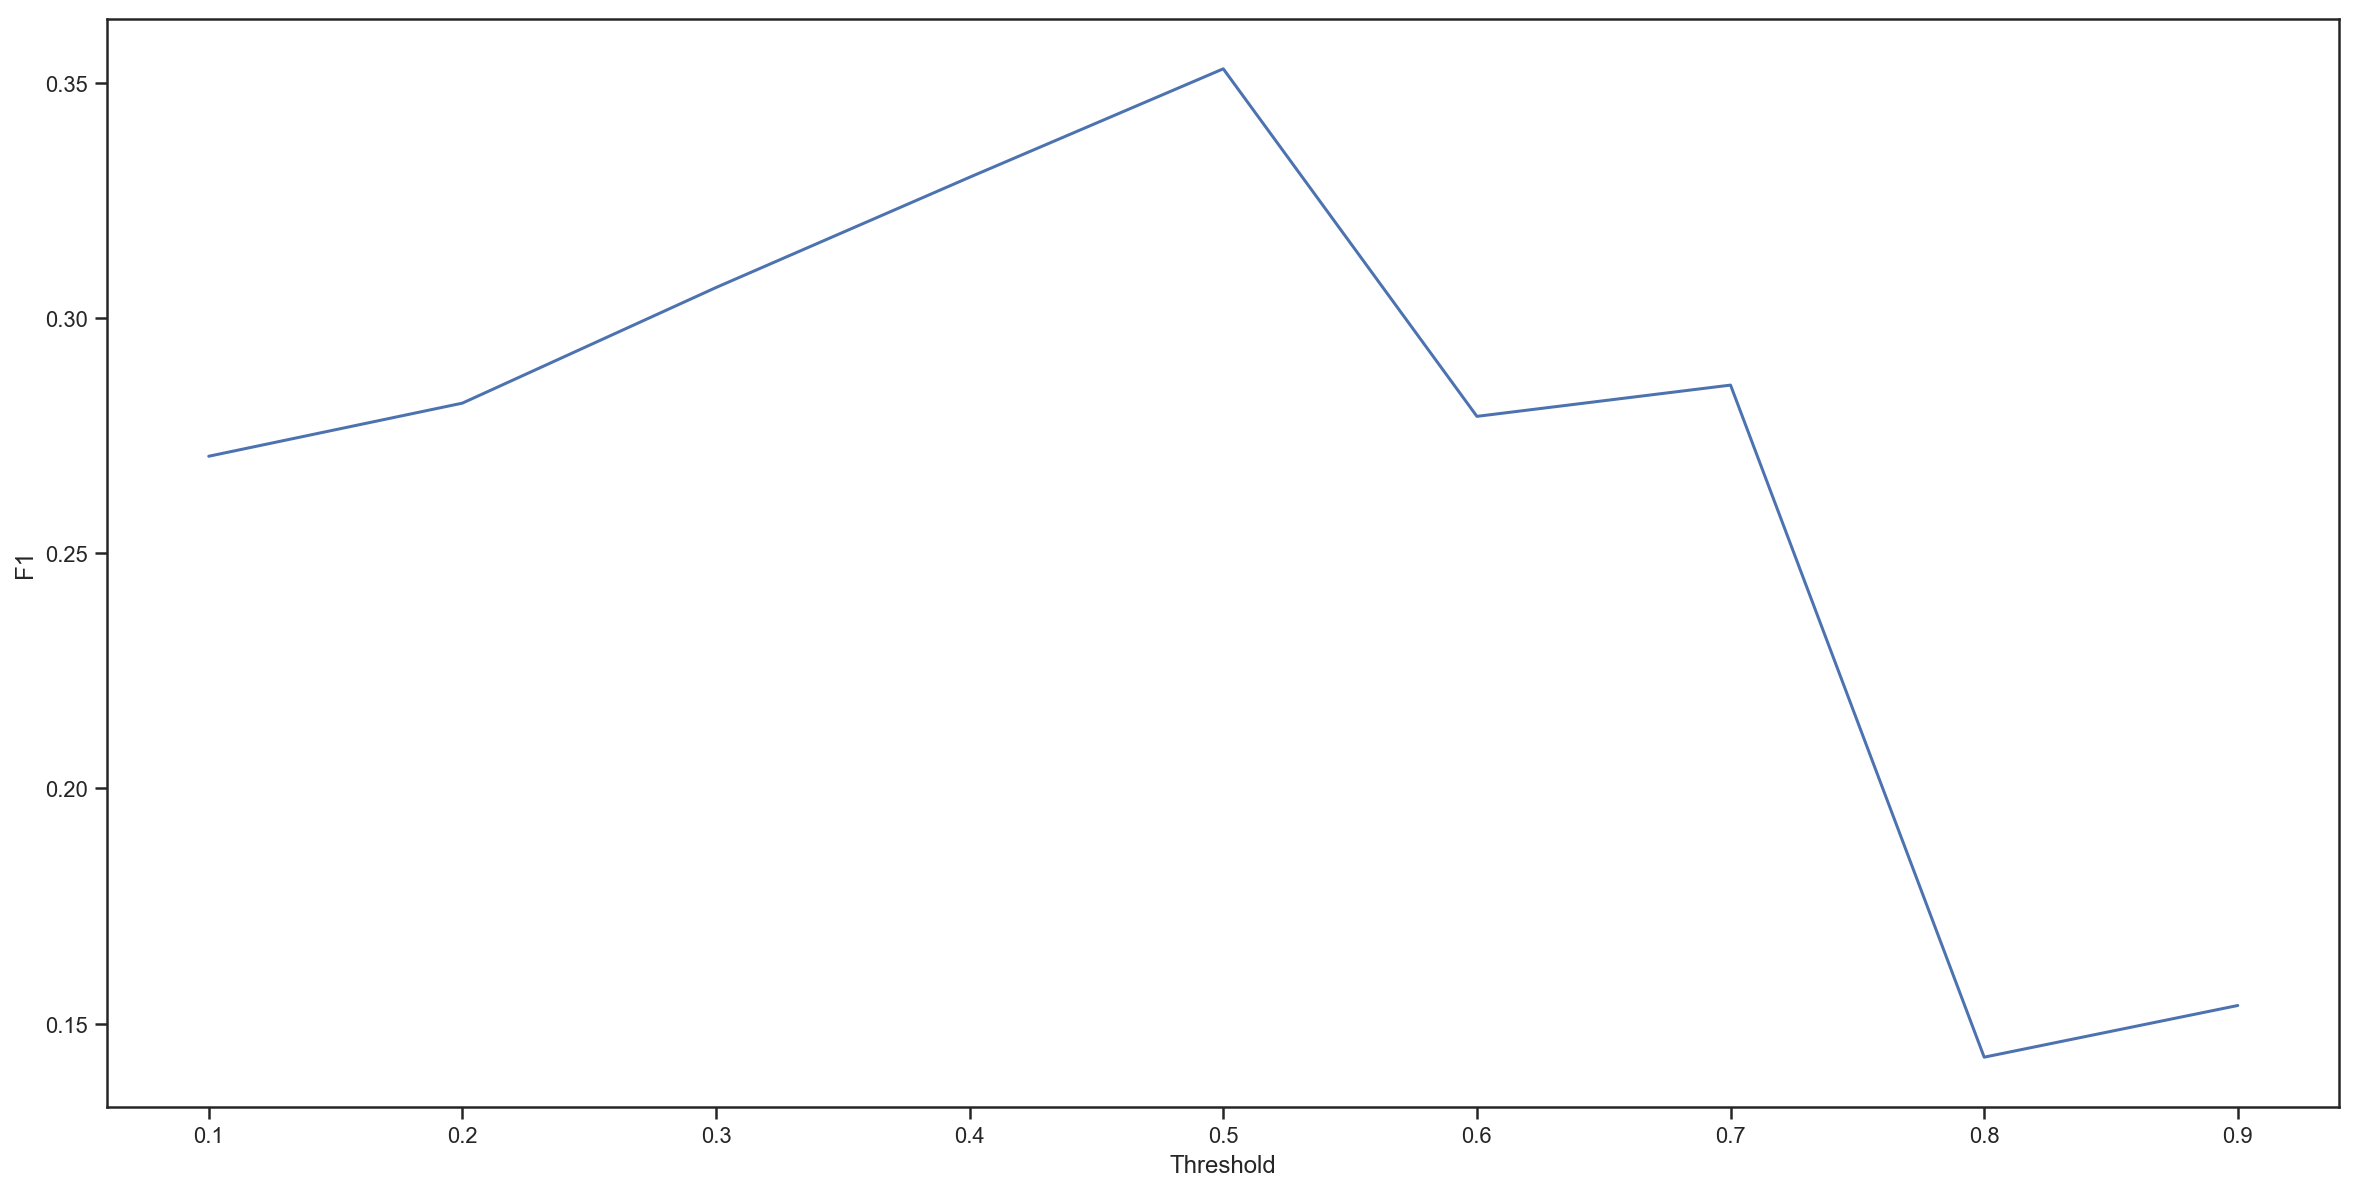

In [168]:
evaluate(predictions14)

In [169]:
# sns.scatterplot(data=predictions14, x="ds", y="yhat", hue="y")